In [4]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ['Opinion', 'Food', 'Movies'],
    ['Art & Design', 'Science', 'Fashion & Style'],
    ['Television', 'Sports', 'Style'],
    ['Music', 'Health', 'Dance'],
    ['Real Estate', 'Books', 'Media'],
    ['Travel', 'Theater', 'Technology']
]
output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

PermissionError: [Errno 13] Permission denied: '/home/youlee/n24news/n24news/captions_and_labels.csv'

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

def tokenize_data(df):
    input_ids, attention_masks = [], []
    
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

class PerceiverBlock(nn.Module):
  
    def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
        super().__init__()
        
        self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
        self.cross_ln = nn.LayerNorm(latent_dim)  # Layer Normalization

    
        self.self_attn_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
            for _ in range(self_attn_layers)
        ])

    def forward(self, latents, x):
        # latents, x: (T, B, dim) 형태로 가정
        # Perceiver 원리상 latents는 query, x는 key/value

       
        updated_latents, _ = self.cross_attn(latents, x, x)
        latents = latents + updated_latents       
        latents = self.cross_ln(latents)        
  
        for layer in self.self_attn_layers:
  
           latents = layer(latents)  
        return latents

class Perceiver(nn.Module):
    def __init__(self, input_dim, latent_dim, latent_size, num_classes,
                 num_blocks, self_attn_layers_per_block=1):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_projection = nn.Linear(input_dim, latent_dim)

        # 여러 개의 PerceiverBlock을 쌓음
        self.blocks = nn.ModuleList([
            PerceiverBlock(
                latent_dim=latent_dim,
                n_heads=8,
                self_attn_layers=self_attn_layers_per_block
            )
            for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        """
        x: (B, T, F) = (배치, 시퀀스 길이, 피처 차원)
        """
        B, T, F = x.size()
        x = self.input_projection(x)                 # (B, T, latent_dim)

        # latents: (latent_size, latent_dim) -> 배치 차원 확장 (B, latent_size, latent_dim)
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)

        # MultiHeadAttention은 (T, B, dim) 순서를 권장하므로 permute
        x = x.permute(1, 0, 2)        # (T, B, latent_dim)
        latents = latents.permute(1, 0, 2)  # (latent_size, B, latent_dim)

        # PerceiverBlock을 여러 번 반복
        for block in self.blocks:
            latents = block(latents, x)

        # 최종 latents: (latent_size, B, latent_dim)
        latents = latents.permute(1, 0, 2).mean(dim=1)  # (B, latent_dim)
        return self.output_layer(latents)

class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, perceiver_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.perceiver = perceiver_model

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)  # (B, T, embed_dim)
        return self.perceiver(embeddings)  


In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  # 현재 코드에서는 사용되지 않음
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  # 현재 코드에서는 사용되지 않음
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


In [7]:
EPOCHS = 15
BATCH_SIZE = 32
K_FOLDS = 5
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수


그룹 1 처리 중...

  폴드 1/5 처리 중...
    에포크 1/15: 학습 손실: 0.9353, 학습 정확도: 0.5007
                               테스트 손실: 0.7583, 테스트 정확도: 0.6054
    에포크 5/15: 학습 손실: 0.2228, 학습 정확도: 0.9278
                               테스트 손실: 0.3898, 테스트 정확도: 0.8745
    에포크 10/15: 학습 손실: 0.0521, 학습 정확도: 0.9856
                               테스트 손실: 0.6074, 테스트 정확도: 0.8662
    에포크 15/15: 학습 손실: 0.0308, 학습 정확도: 0.9905
                               테스트 손실: 0.6830, 테스트 정확도: 0.8551

  폴드 2/5 처리 중...
    에포크 1/15: 학습 손실: 0.8972, 학습 정확도: 0.5582
                               테스트 손실: 0.6101, 테스트 정확도: 0.7814
    에포크 5/15: 학습 손실: 0.1727, 학습 정확도: 0.9457
                               테스트 손실: 0.4116, 테스트 정확도: 0.8793
    에포크 10/15: 학습 손실: 0.0551, 학습 정확도: 0.9851
                               테스트 손실: 0.5153, 테스트 정확도: 0.8799
    에포크 15/15: 학습 손실: 0.0235, 학습 정확도: 0.9948
                               테스트 손실: 0.6536, 테스트 정확도: 0.8744

  폴드 3/5 처리 중...
    에포크 1/15: 학습 손실: 0.9296, 학습 정확도: 0.5114
                            

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missin

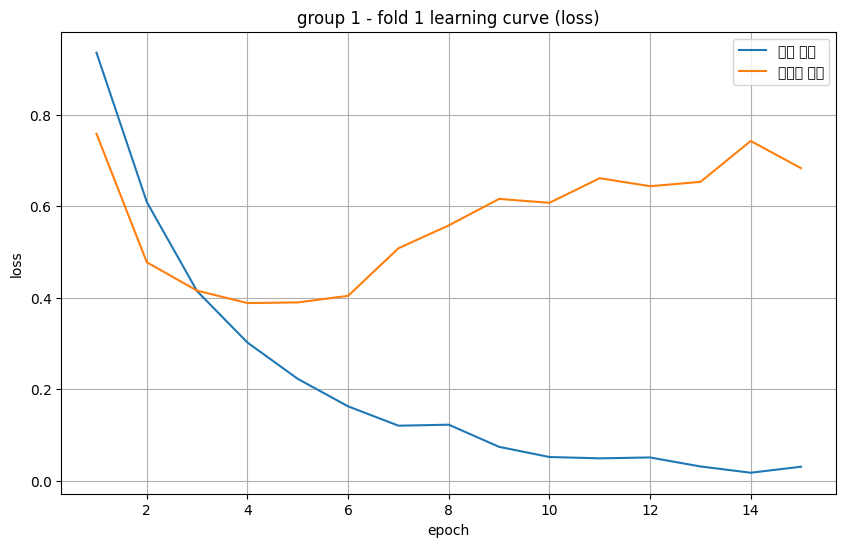

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


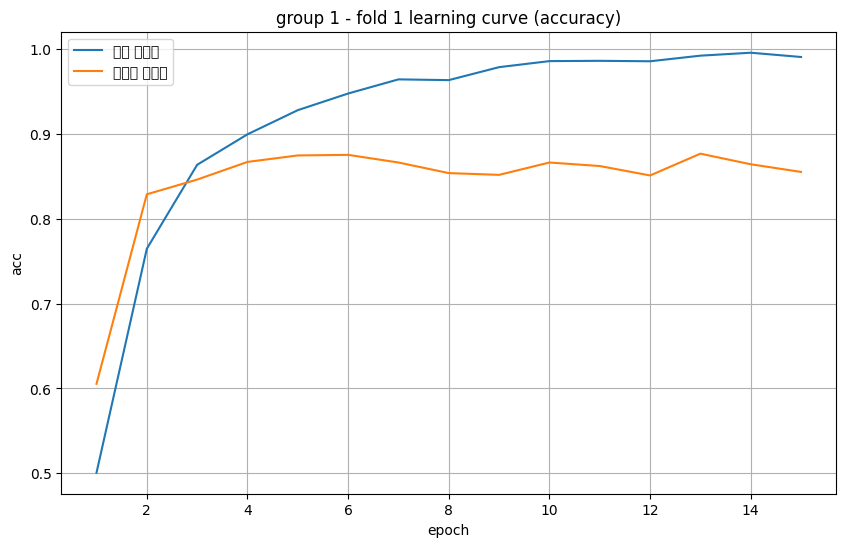

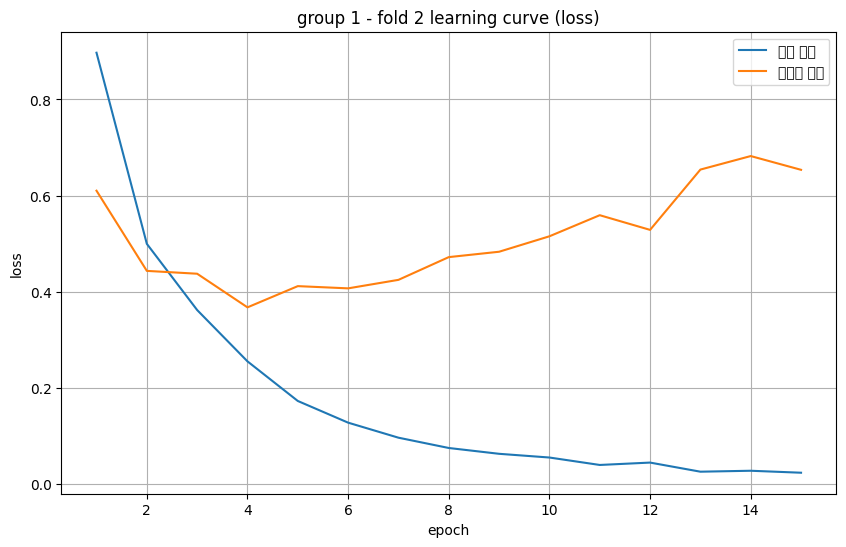

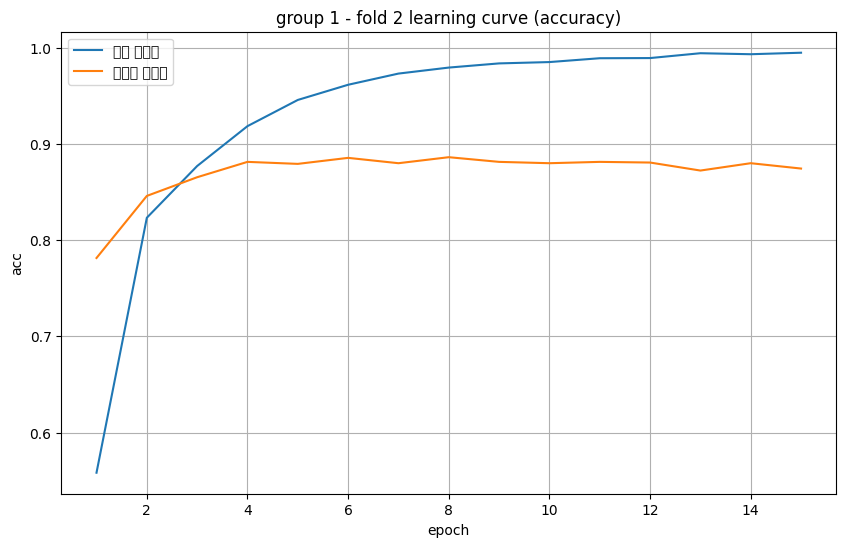

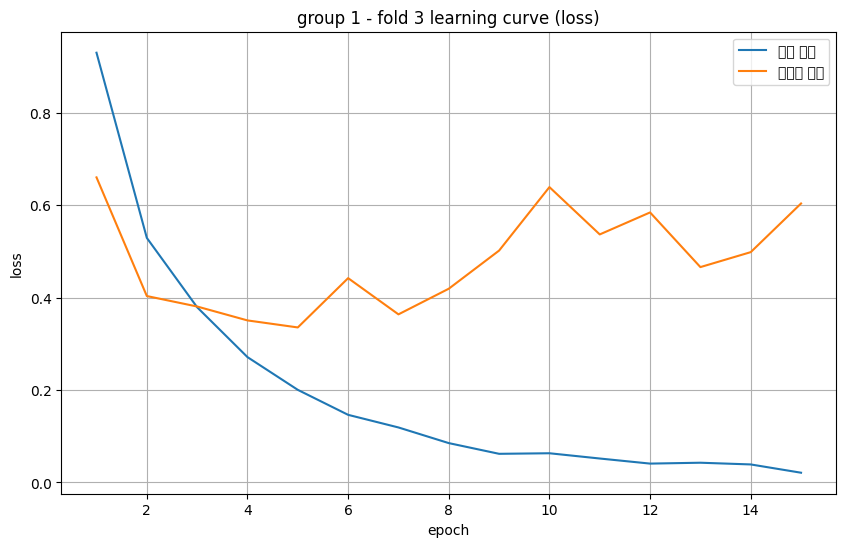

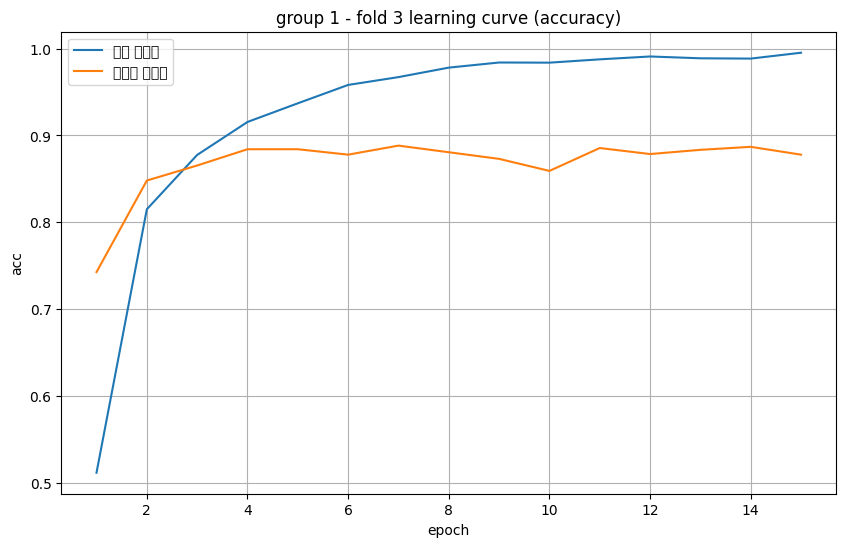

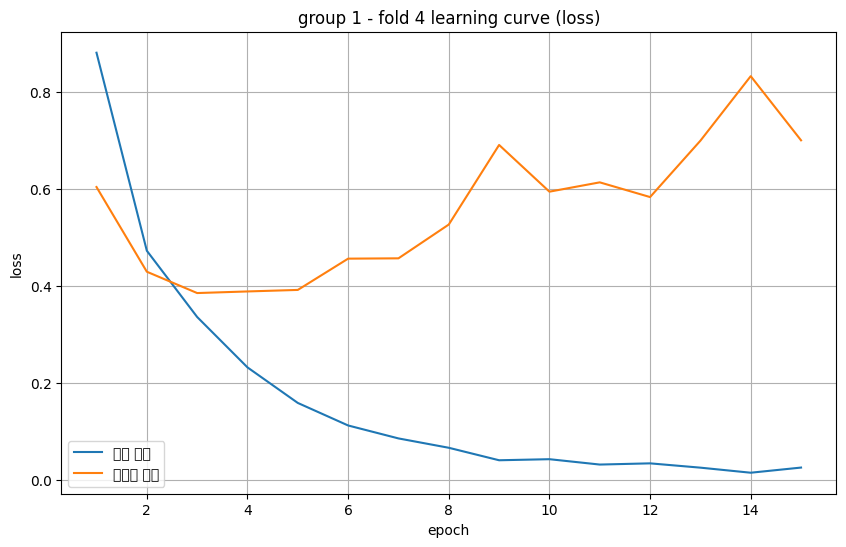

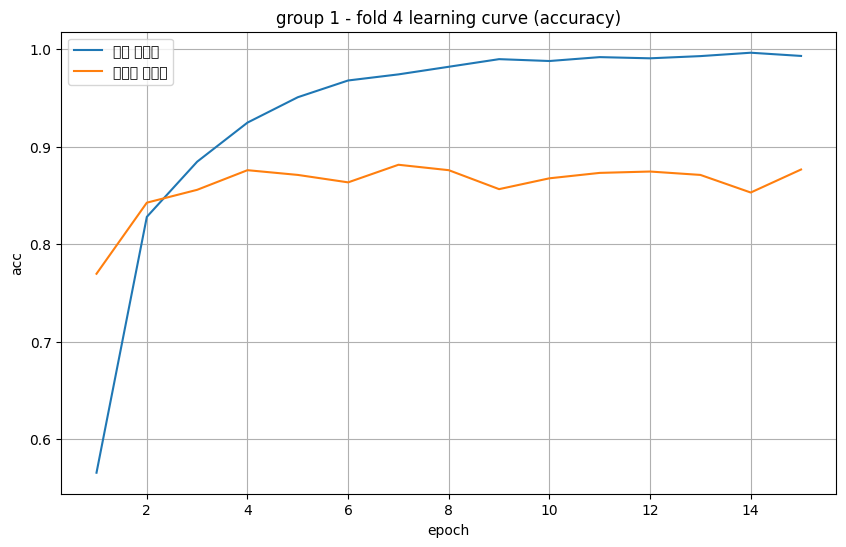

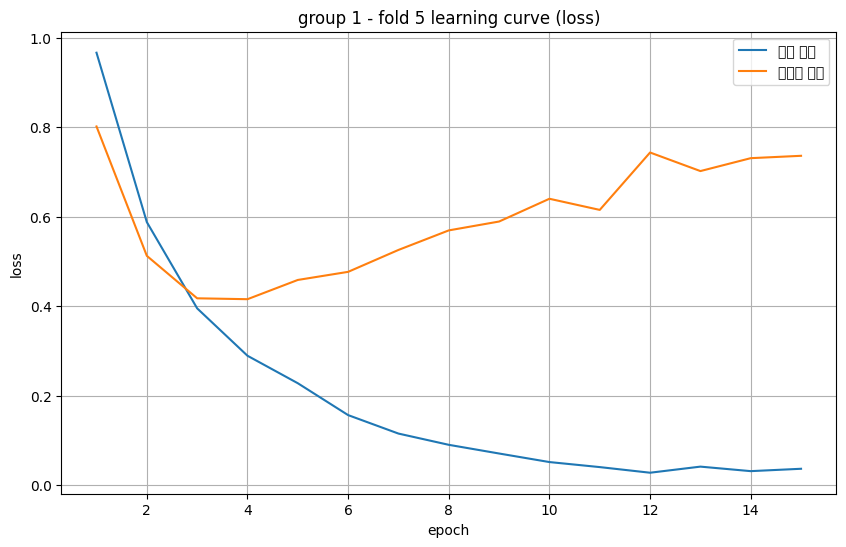

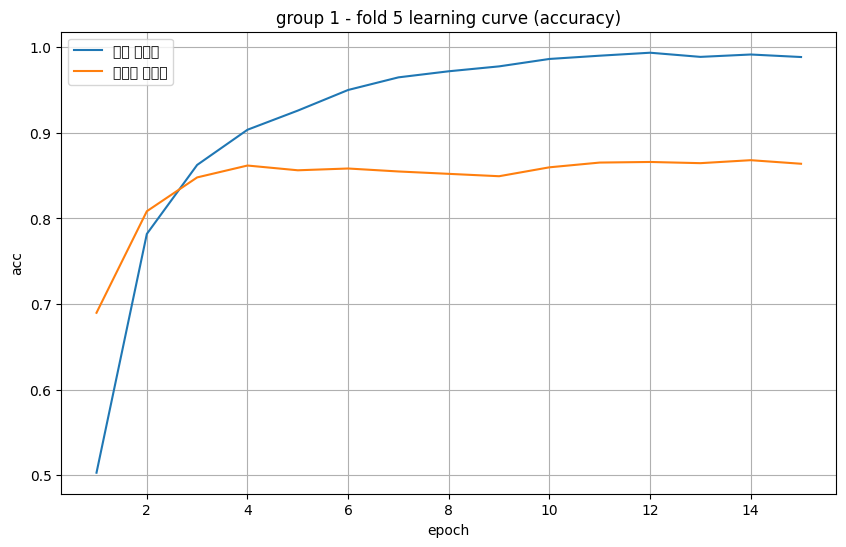

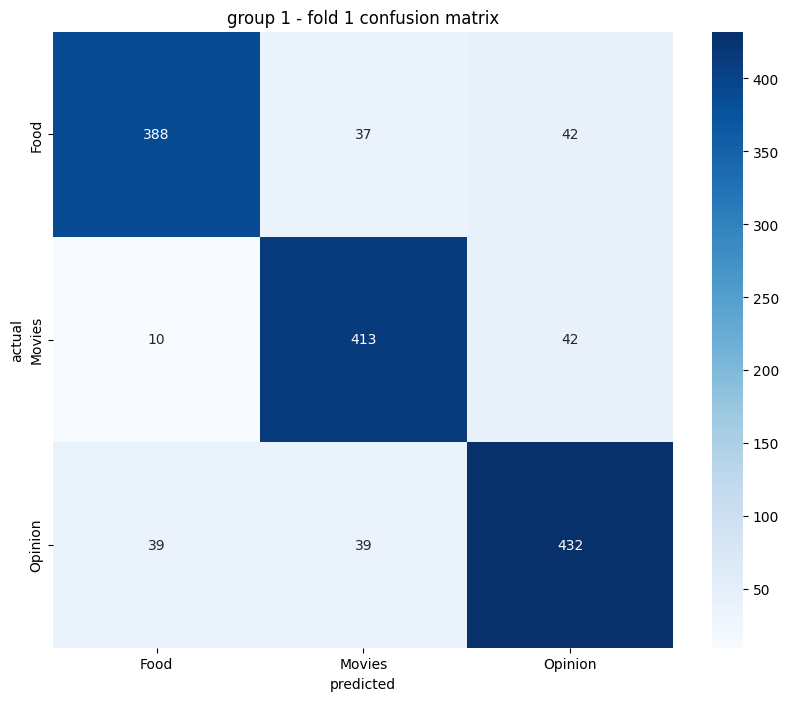

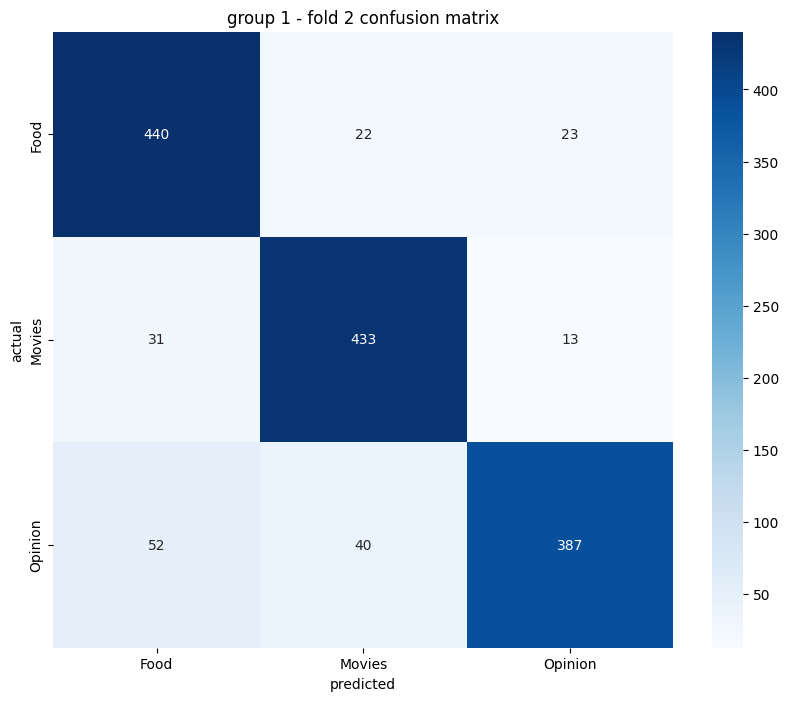

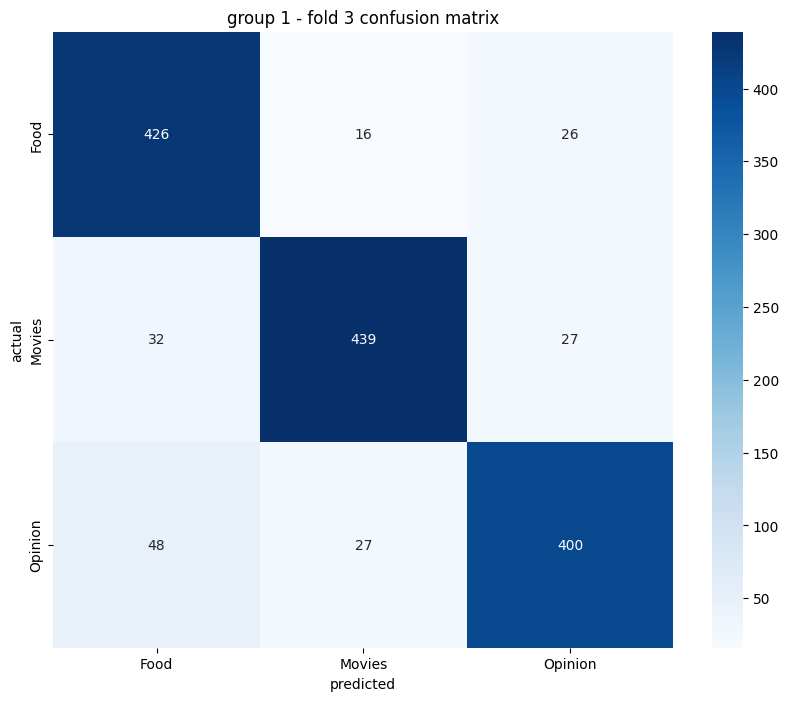

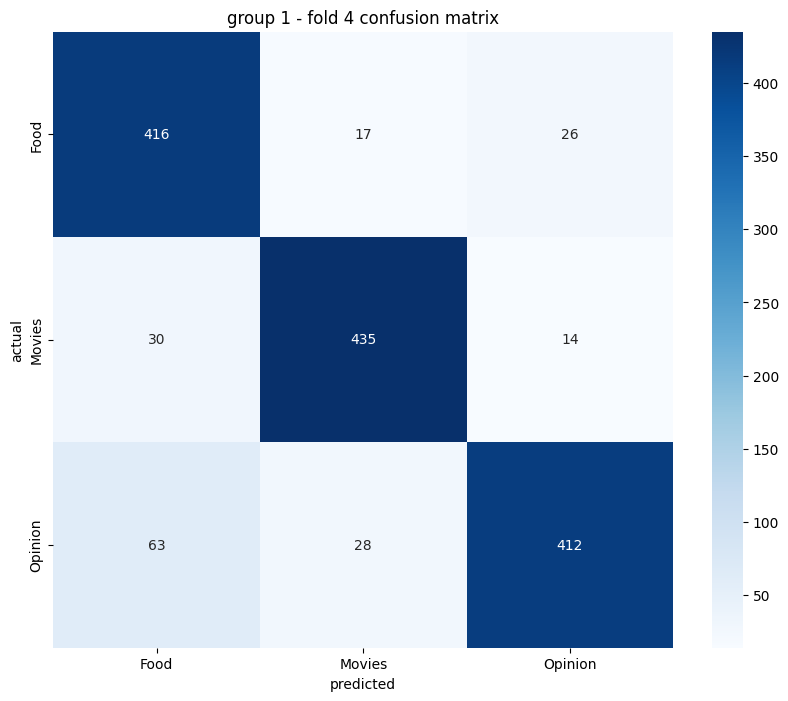

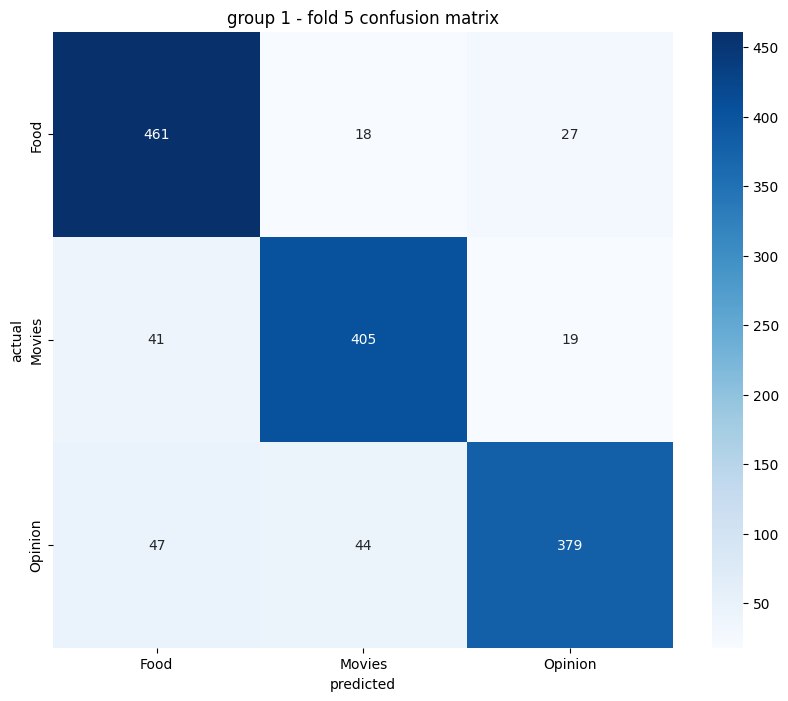


그룹 2 처리 중...

  폴드 1/5 처리 중...
    에포크 1/15: 학습 손실: 1.0137, 학습 정확도: 0.4865
                               테스트 손실: 0.8711, 테스트 정확도: 0.6232
    에포크 5/15: 학습 손실: 0.2938, 학습 정확도: 0.8947
                               테스트 손실: 0.4677, 테스트 정확도: 0.8223
    에포크 10/15: 학습 손실: 0.0552, 학습 정확도: 0.9863
                               테스트 손실: 0.8310, 테스트 정확도: 0.8050
    에포크 15/15: 학습 손실: 0.0250, 학습 정확도: 0.9938
                               테스트 손실: 0.9405, 테스트 정확도: 0.8112

  폴드 2/5 처리 중...
    에포크 1/15: 학습 손실: 1.0009, 학습 정확도: 0.5049
                               테스트 손실: 0.8676, 테스트 정확도: 0.6225
    에포크 5/15: 학습 손실: 0.2566, 학습 정확도: 0.9092
                               테스트 손실: 0.5949, 테스트 정확도: 0.8071
    에포크 10/15: 학습 손실: 0.0464, 학습 정확도: 0.9859
                               테스트 손실: 1.0159, 테스트 정확도: 0.7863
    에포크 15/15: 학습 손실: 0.0234, 학습 정확도: 0.9944
                               테스트 손실: 1.0995, 테스트 정확도: 0.7814

  폴드 3/5 처리 중...
    에포크 1/15: 학습 손실: 1.0339, 학습 정확도: 0.4594
                            

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missin

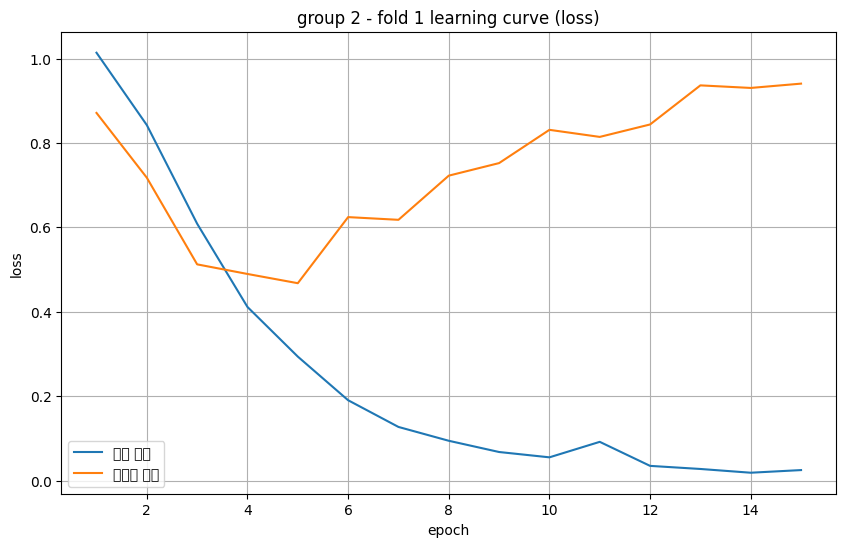

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


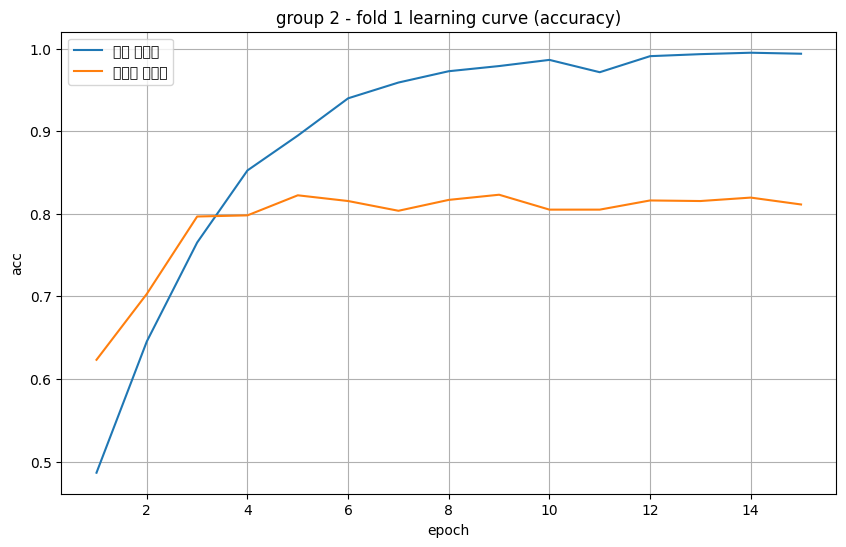

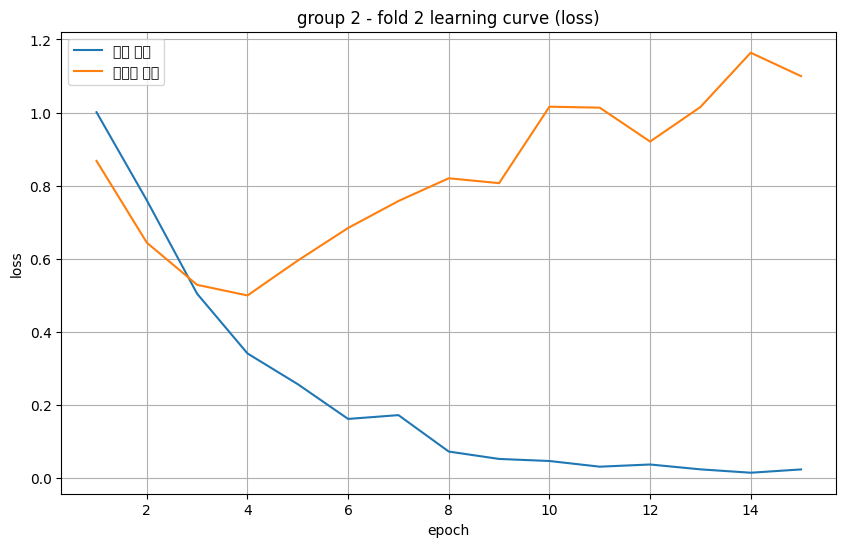

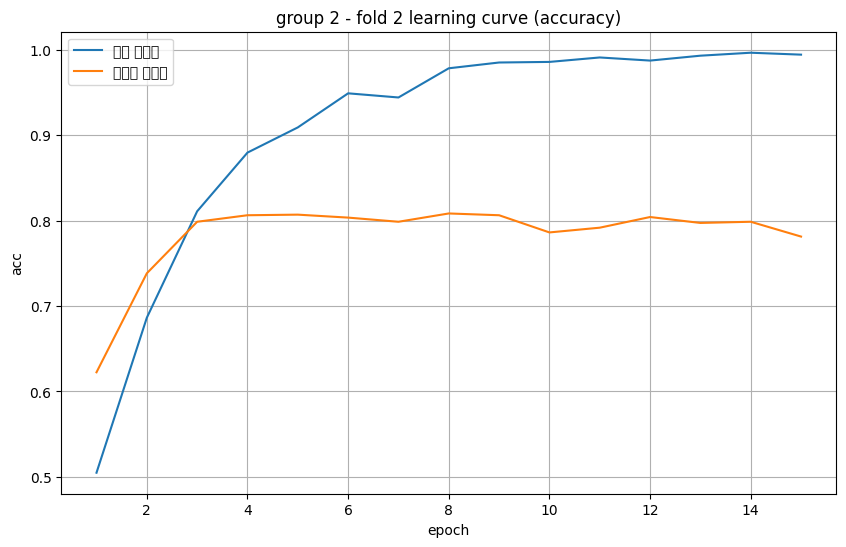

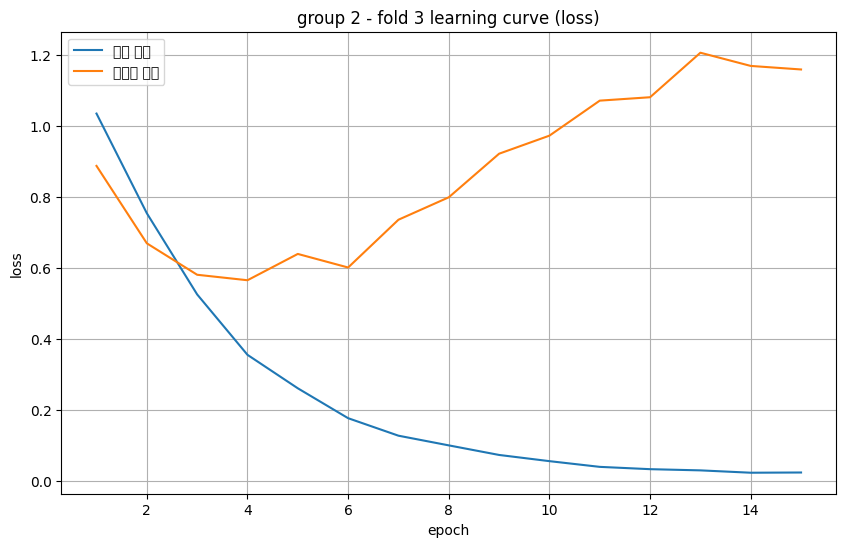

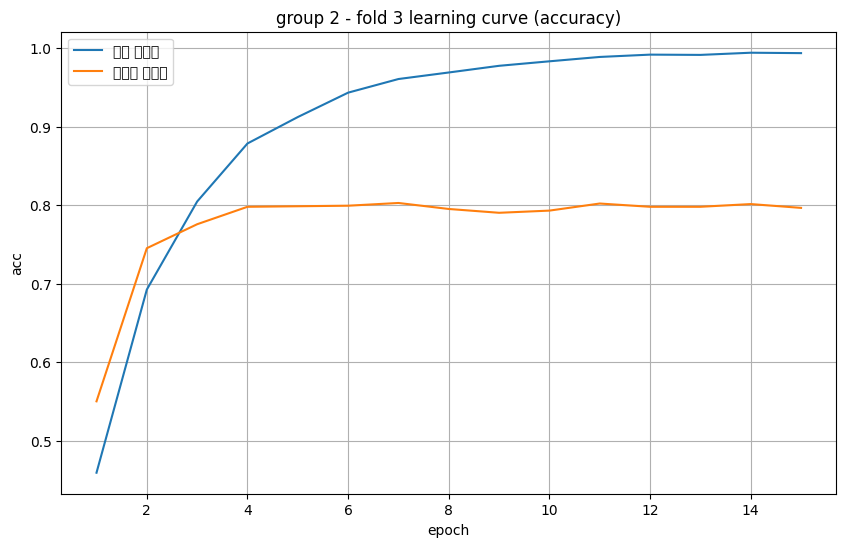

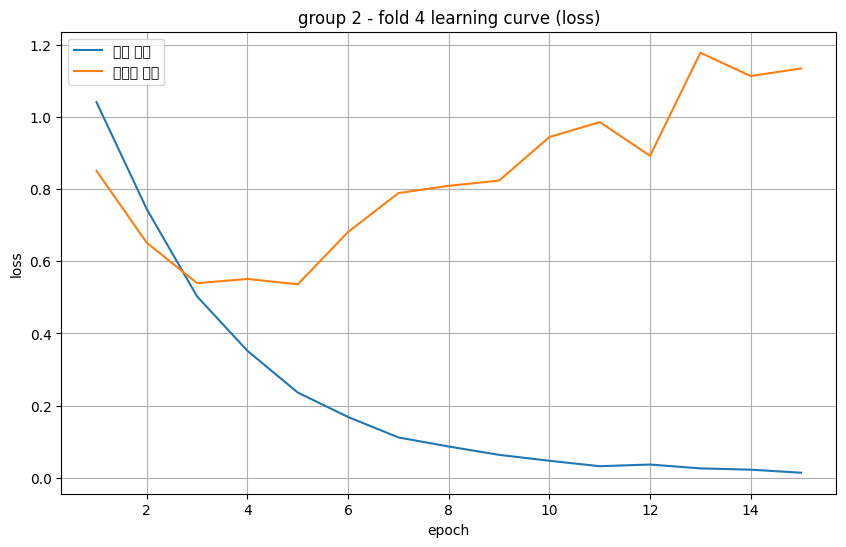

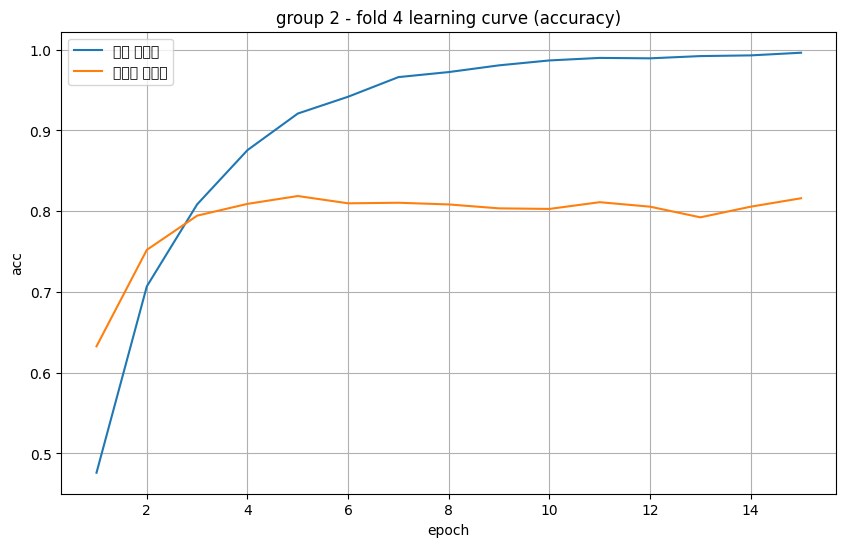

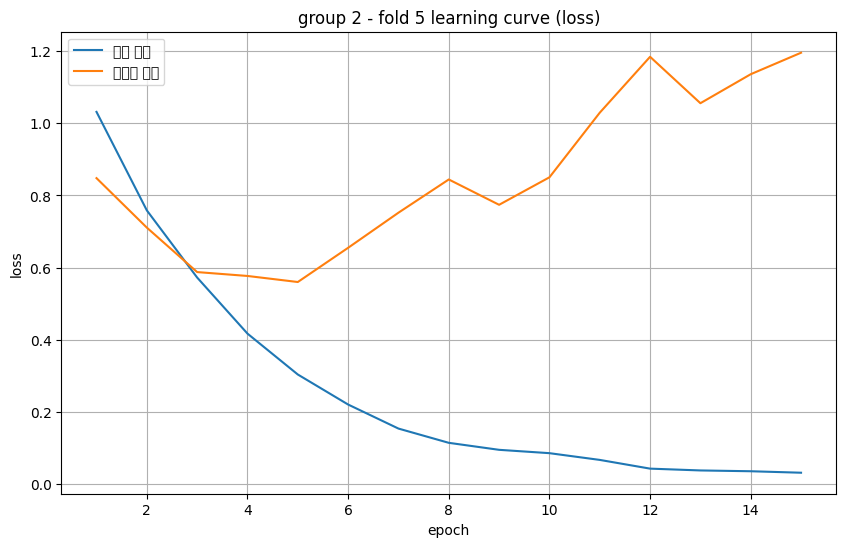

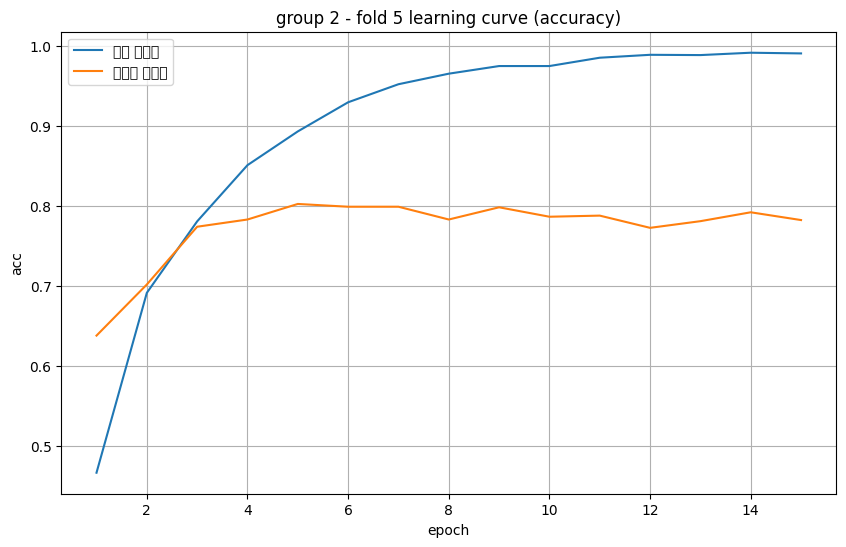

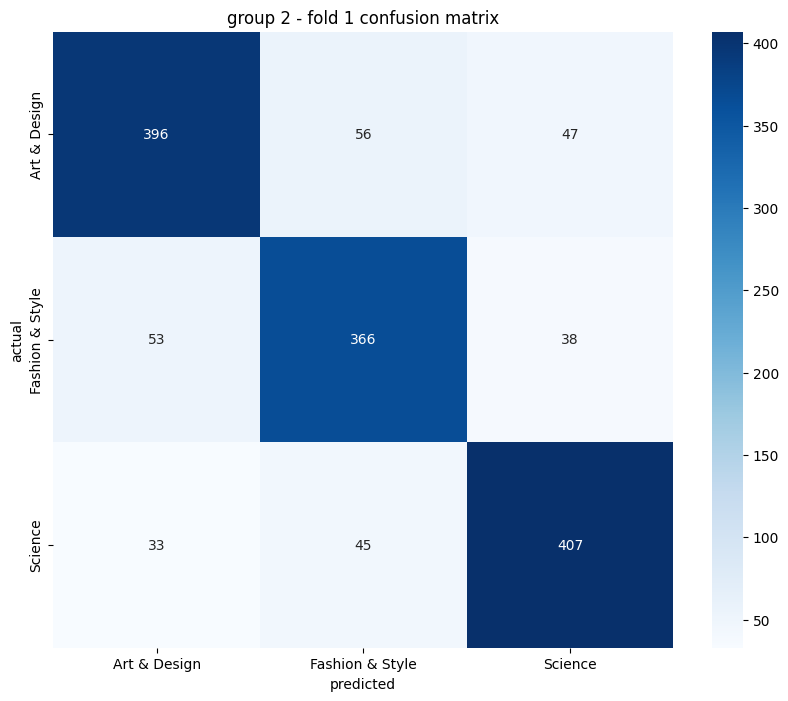

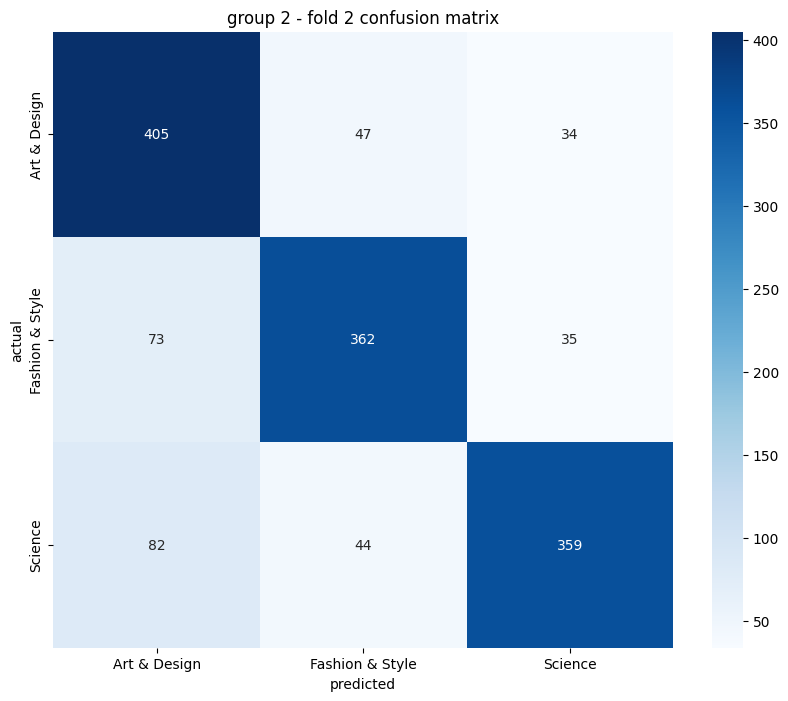

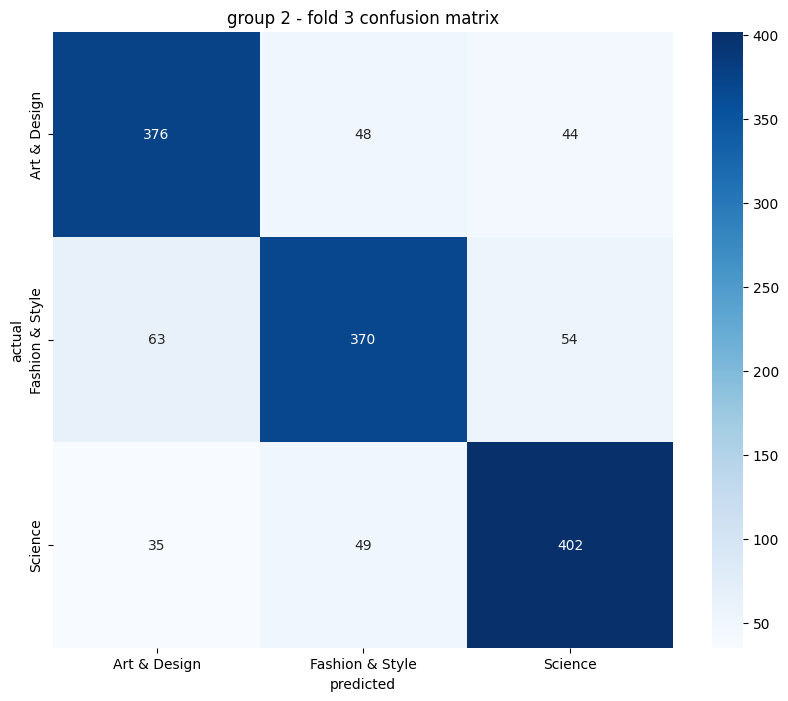

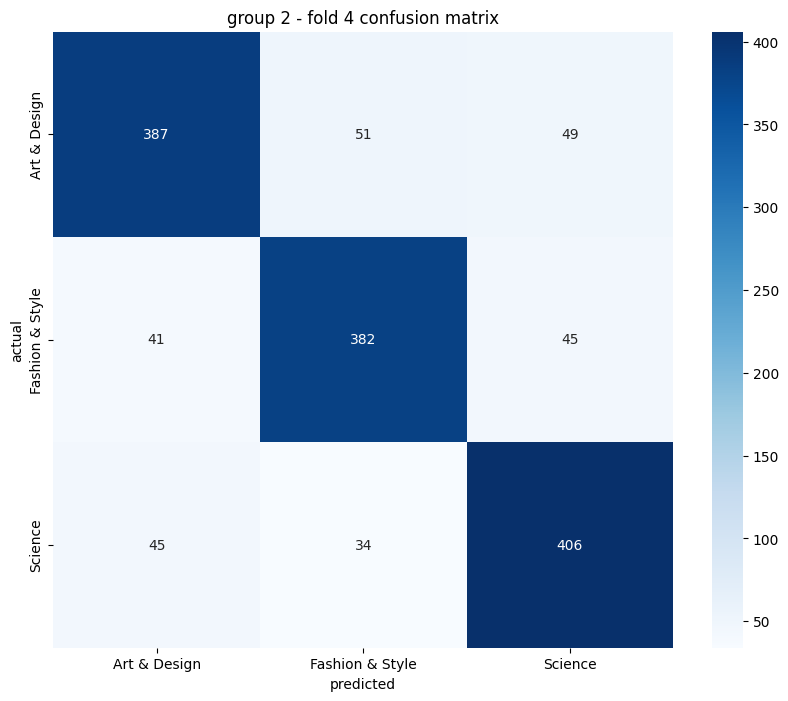

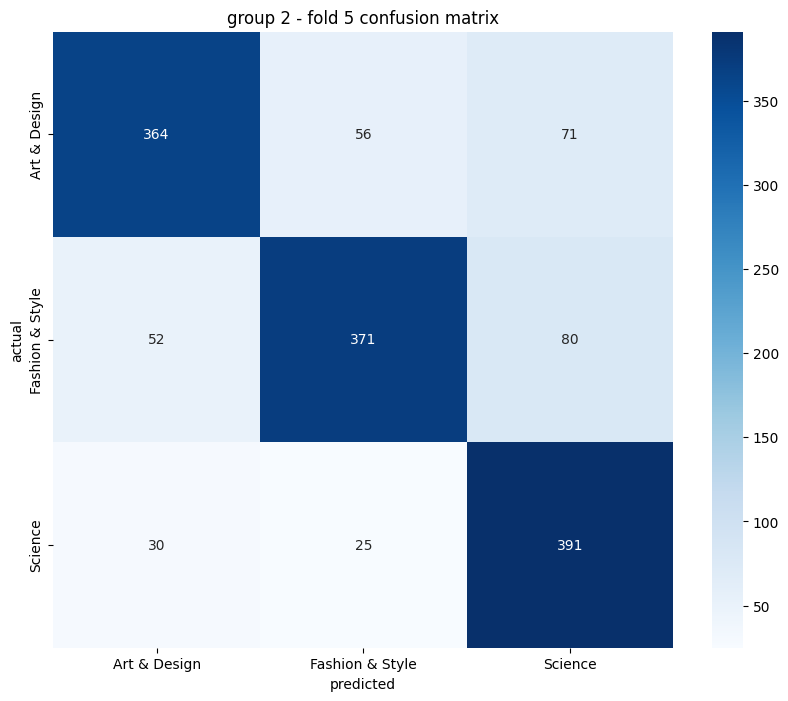


그룹 3 처리 중...

  폴드 1/5 처리 중...
    에포크 1/15: 학습 손실: 0.9984, 학습 정확도: 0.4946
                               테스트 손실: 0.8592, 테스트 정확도: 0.6100
    에포크 5/15: 학습 손실: 0.3394, 학습 정확도: 0.8799
                               테스트 손실: 0.4880, 테스트 정확도: 0.8287
    에포크 10/15: 학습 손실: 0.0871, 학습 정확도: 0.9762
                               테스트 손실: 0.7168, 테스트 정확도: 0.8194
    에포크 15/15: 학습 손실: 0.0425, 학습 정확도: 0.9876
                               테스트 손실: 0.9125, 테스트 정확도: 0.8115

  폴드 2/5 처리 중...
    에포크 1/15: 학습 손실: 0.9755, 학습 정확도: 0.5174
                               테스트 손실: 0.7479, 테스트 정확도: 0.6982
    에포크 5/15: 학습 손실: 0.2444, 학습 정확도: 0.9161
                               테스트 손실: 0.6039, 테스트 정확도: 0.8065
    에포크 10/15: 학습 손실: 0.0607, 학습 정확도: 0.9824
                               테스트 손실: 0.7821, 테스트 정확도: 0.8007
    에포크 15/15: 학습 손실: 0.0278, 학습 정확도: 0.9923
                               테스트 손실: 1.0659, 테스트 정확도: 0.7892

  폴드 3/5 처리 중...
    에포크 1/15: 학습 손실: 0.9335, 학습 정확도: 0.5333
                            

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missin

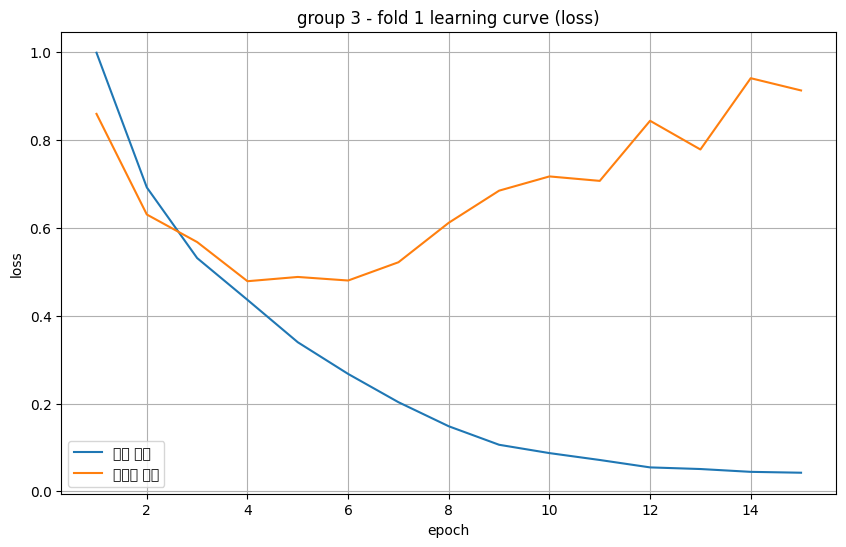

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


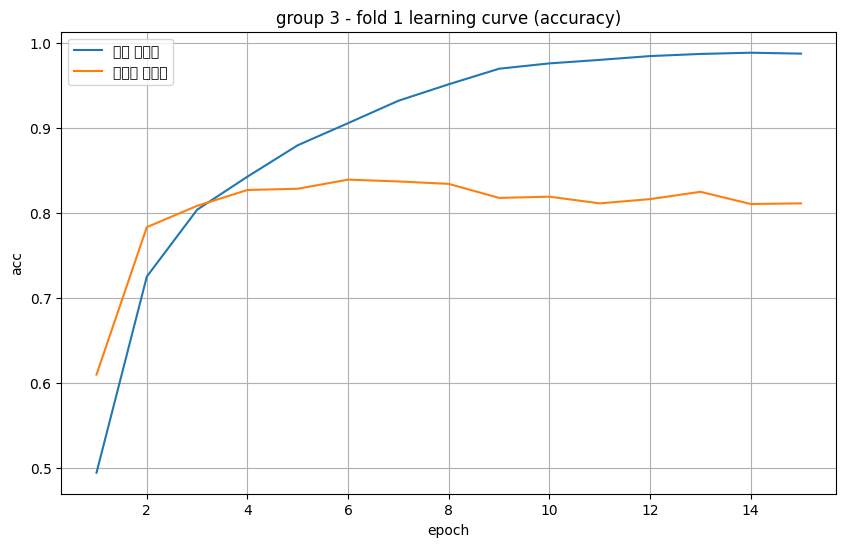

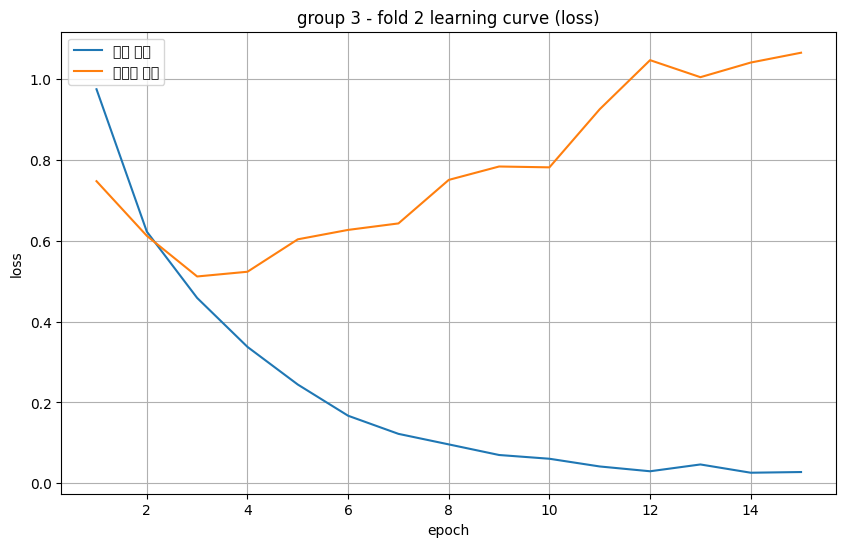

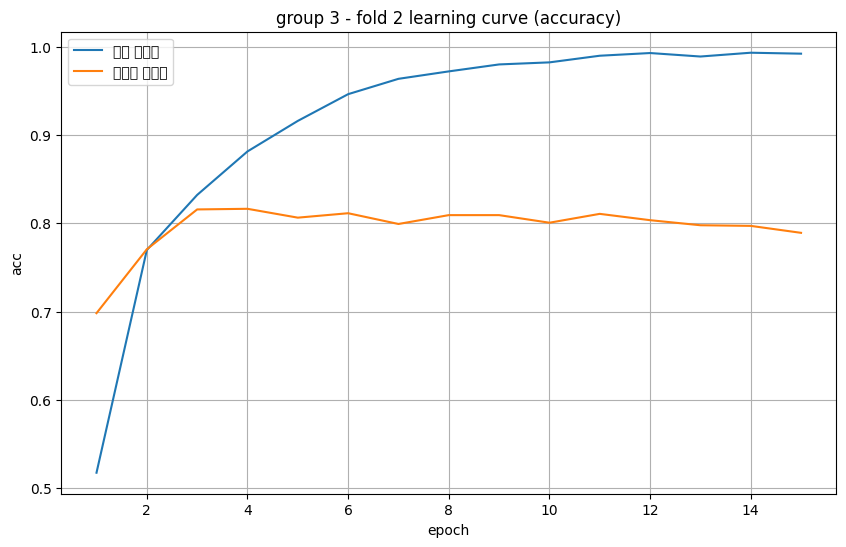

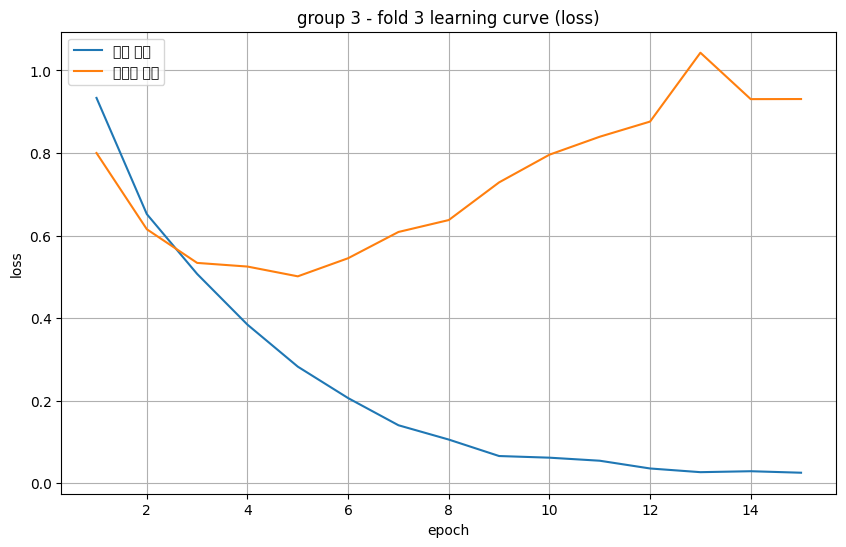

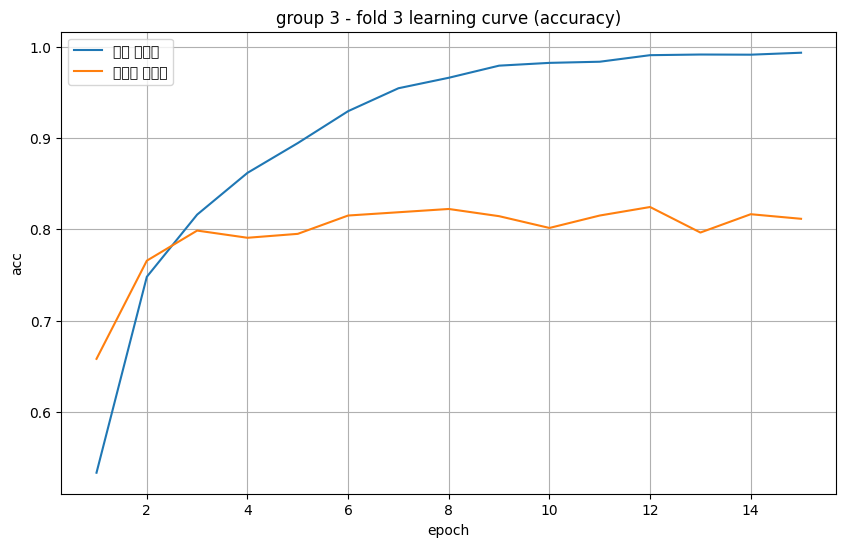

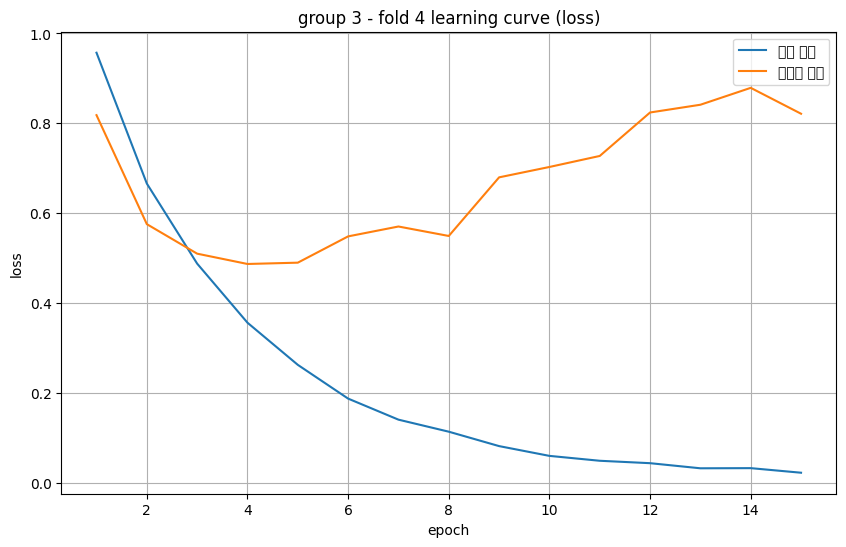

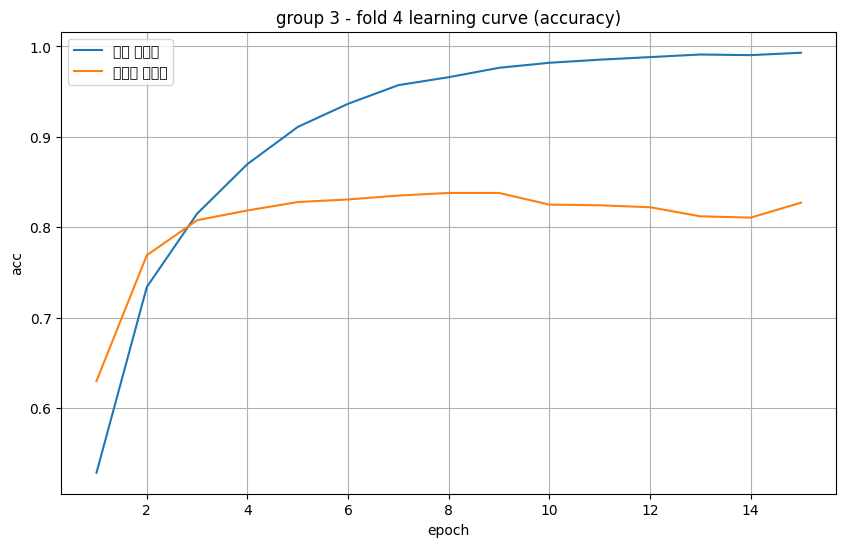

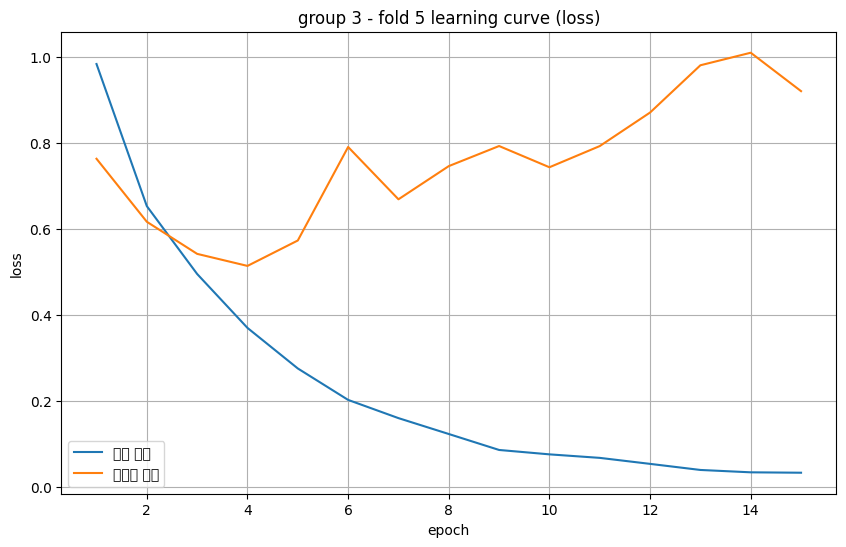

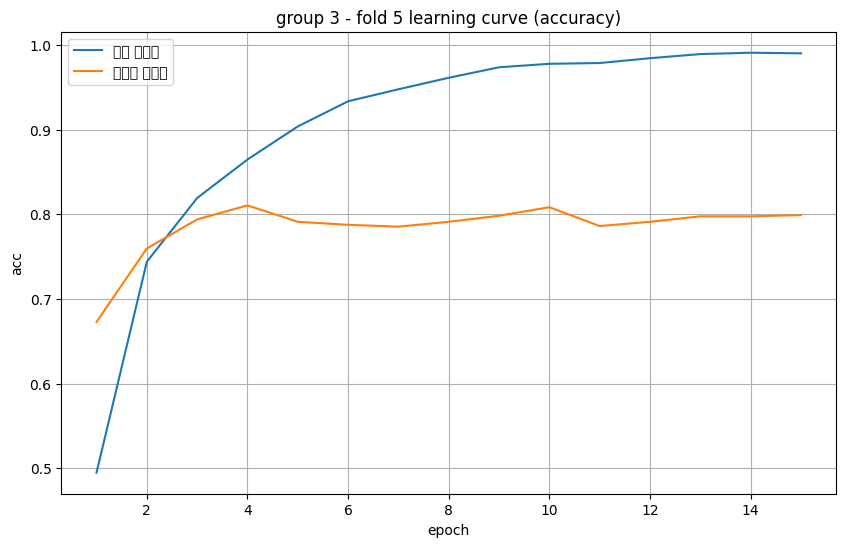

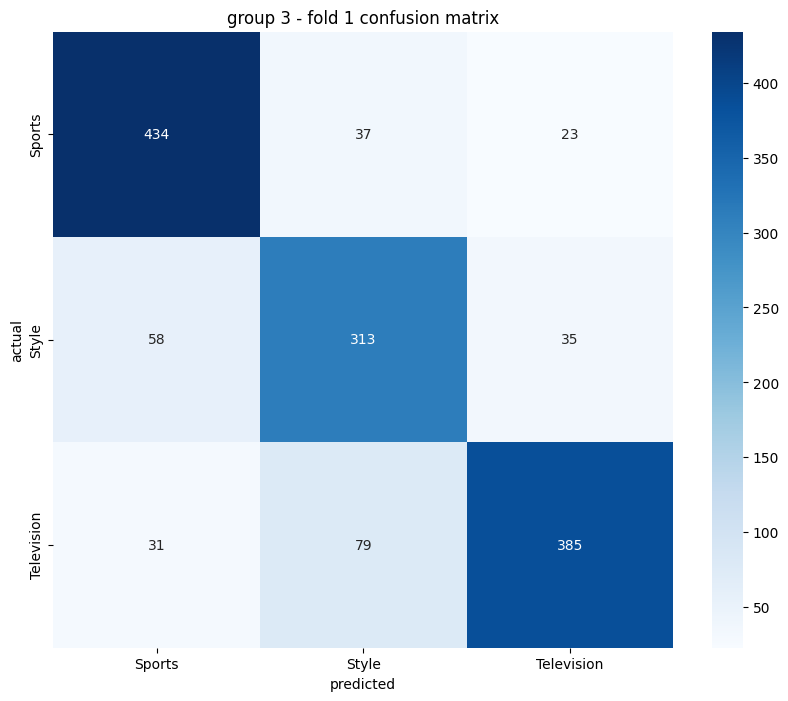

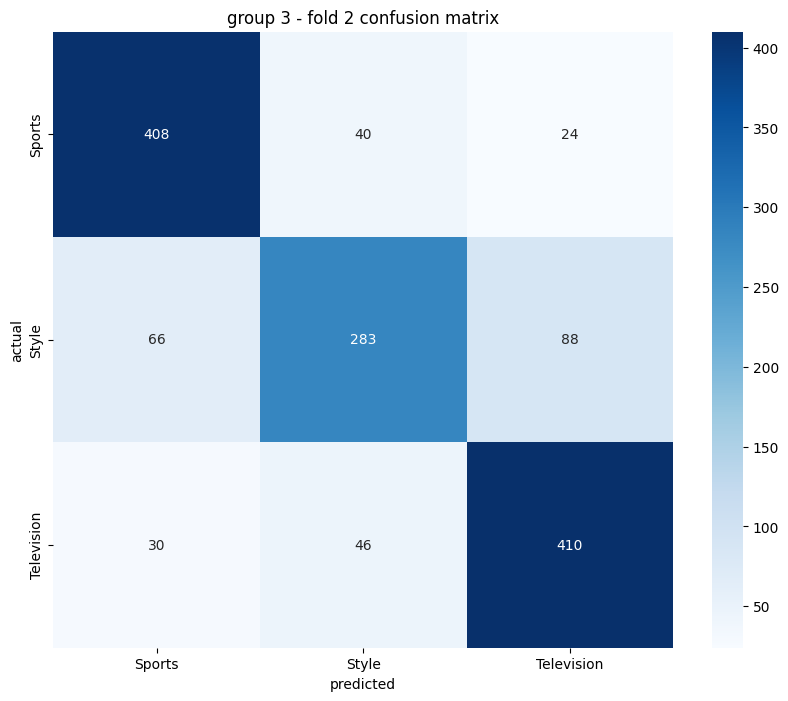

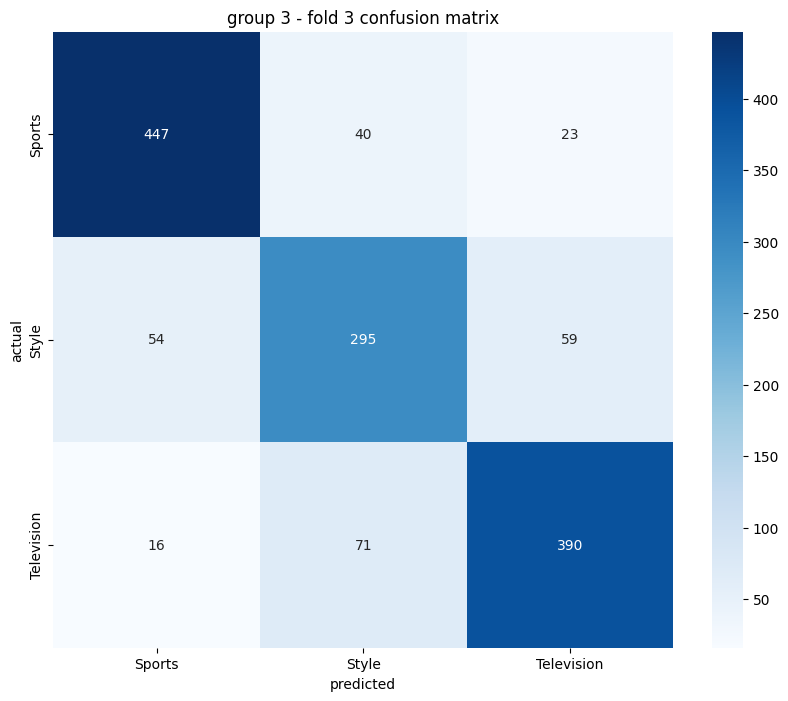

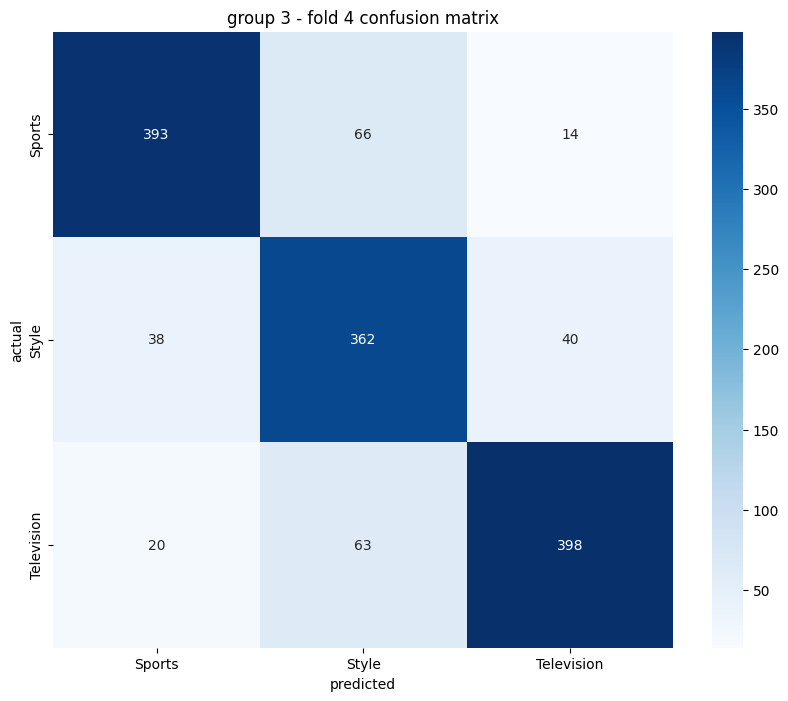

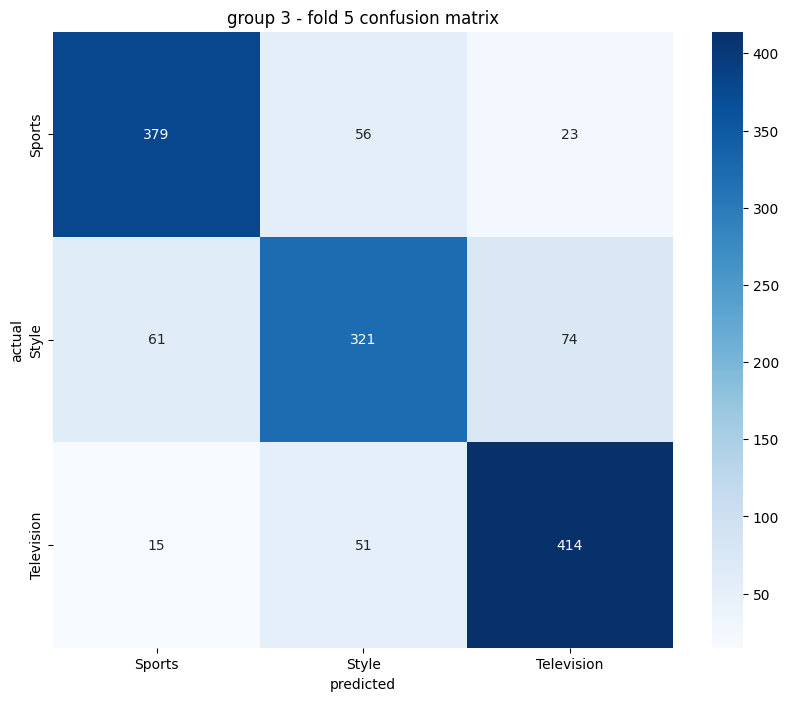


그룹 4 처리 중...

  폴드 1/5 처리 중...
    에포크 1/15: 학습 손실: 1.0424, 학습 정확도: 0.4374
                               테스트 손실: 0.7913, 테스트 정확도: 0.6592
    에포크 5/15: 학습 손실: 0.1519, 학습 정확도: 0.9478
                               테스트 손실: 0.3926, 테스트 정확도: 0.8686
    에포크 10/15: 학습 손실: 0.0396, 학습 정확도: 0.9866
                               테스트 손실: 0.5755, 테스트 정확도: 0.8797
    에포크 15/15: 학습 손실: 0.0072, 학습 정확도: 0.9990
                               테스트 손실: 0.7265, 테스트 정확도: 0.8811

  폴드 2/5 처리 중...
    에포크 1/15: 학습 손실: 0.9775, 학습 정확도: 0.4880
                               테스트 손실: 0.6493, 테스트 정확도: 0.7079
    에포크 5/15: 학습 손실: 0.1492, 학습 정확도: 0.9508
                               테스트 손실: 0.4279, 테스트 정확도: 0.8547
    에포크 10/15: 학습 손실: 0.0228, 학습 정확도: 0.9939
                               테스트 손실: 0.7017, 테스트 정확도: 0.8630
    에포크 15/15: 학습 손실: 0.0204, 학습 정확도: 0.9937
                               테스트 손실: 0.6618, 테스트 정확도: 0.8727

  폴드 3/5 처리 중...
    에포크 1/15: 학습 손실: 1.0382, 학습 정확도: 0.4379
                            

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missin

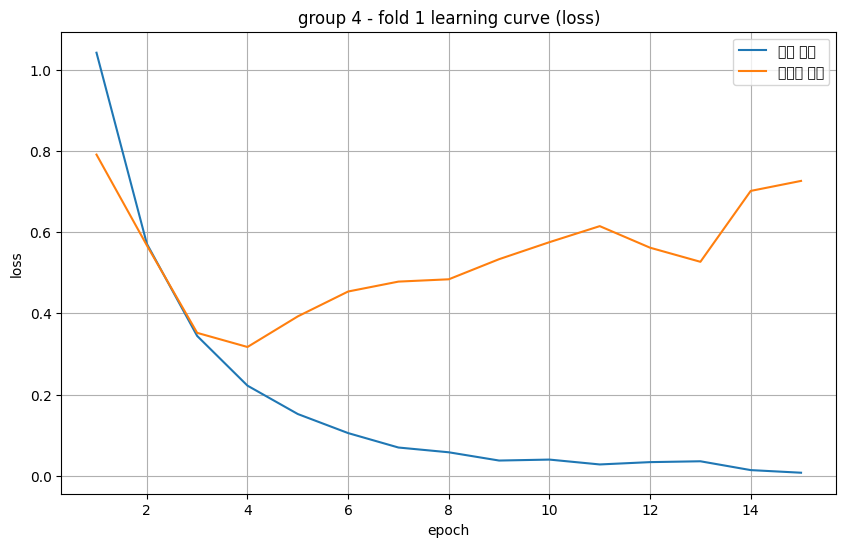

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


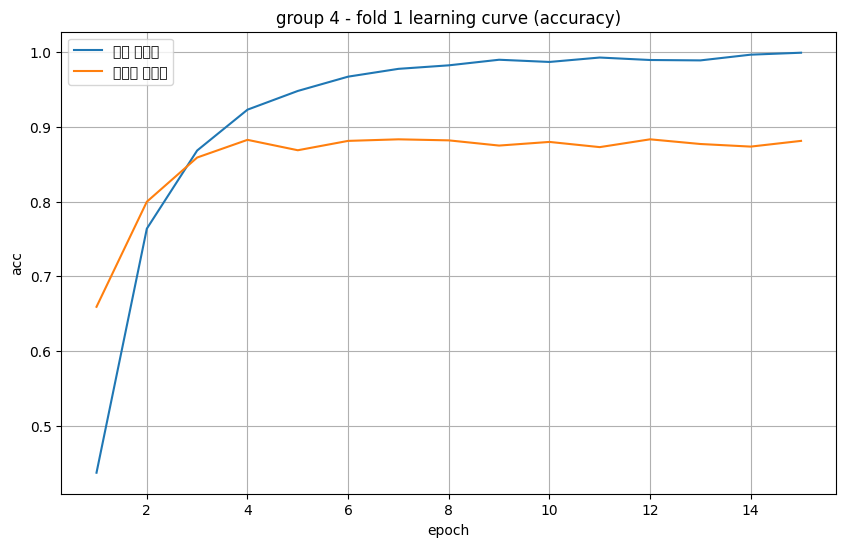

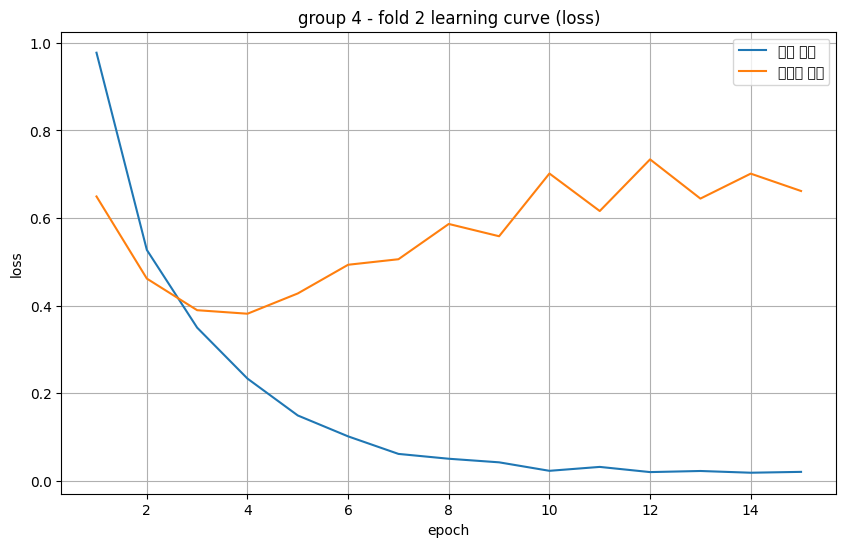

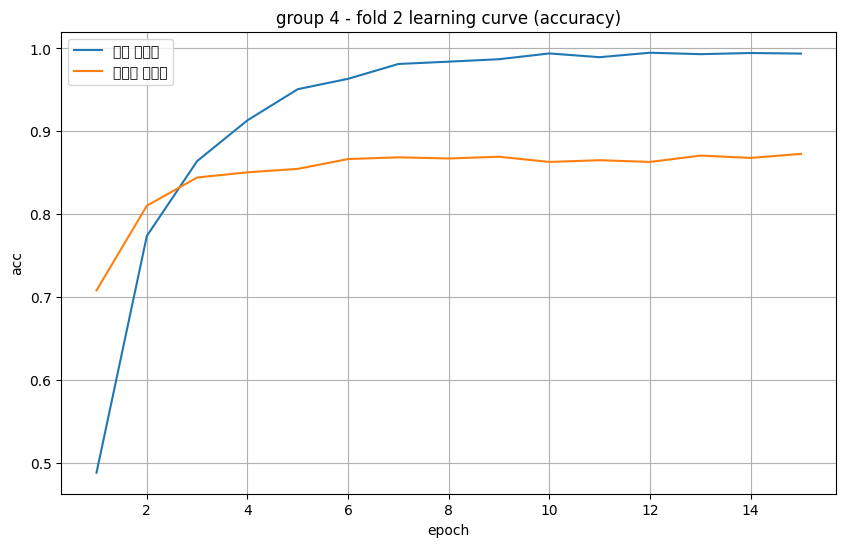

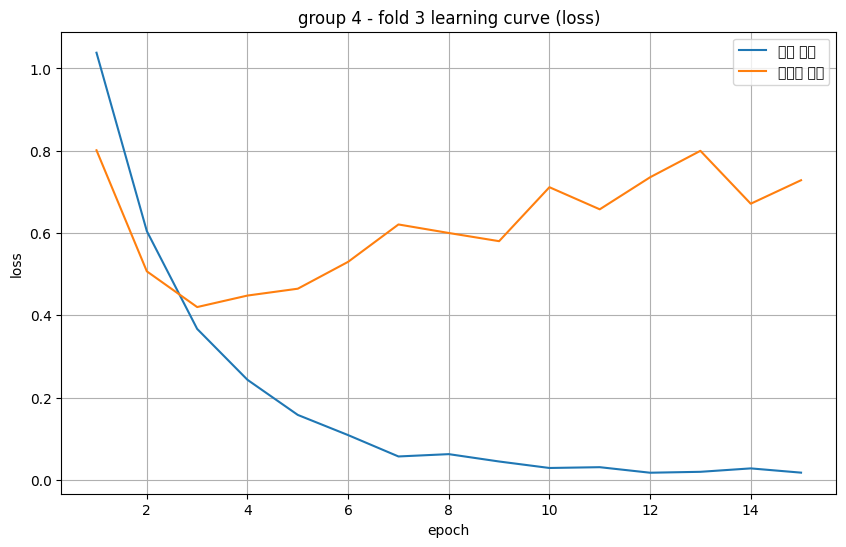

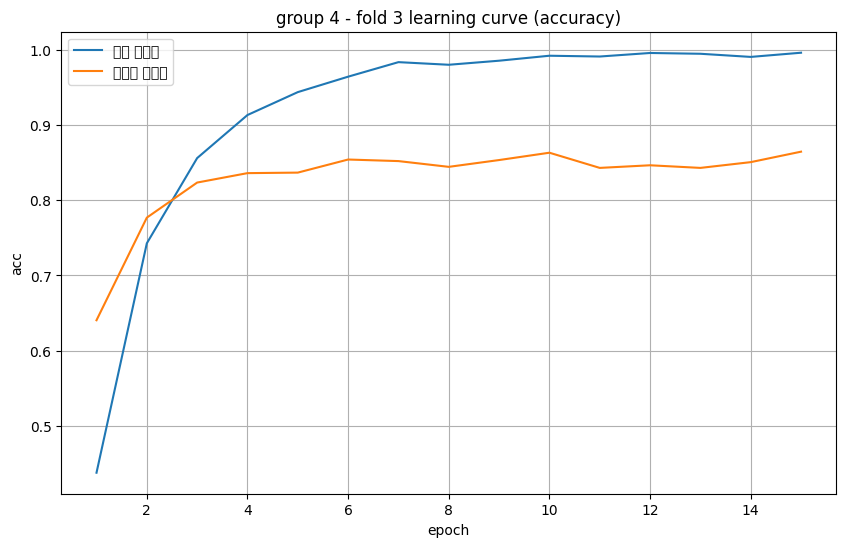

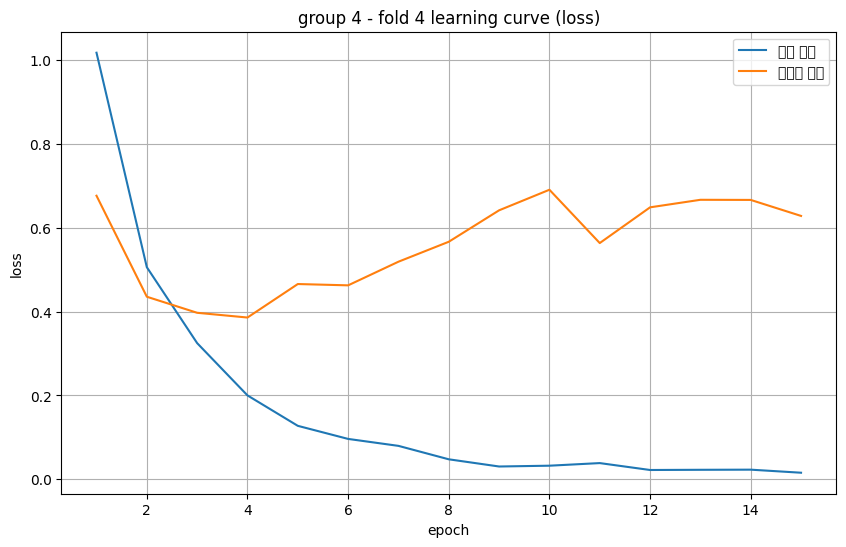

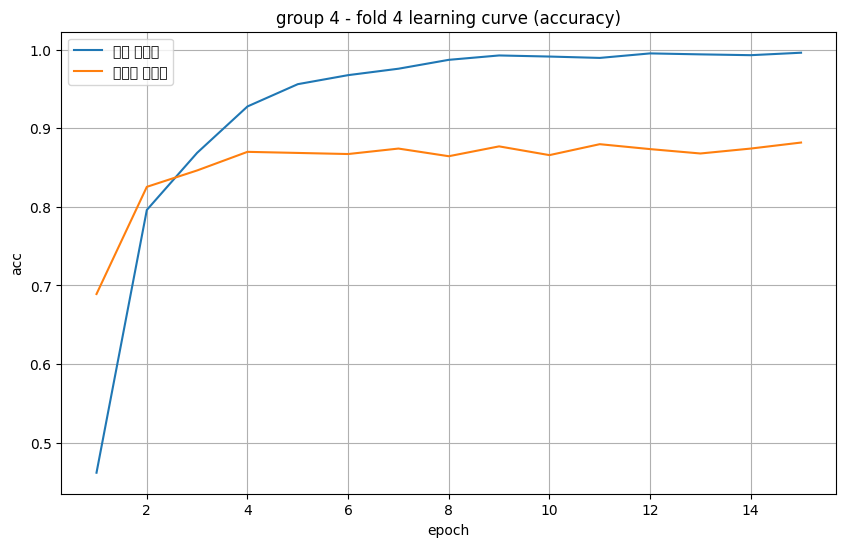

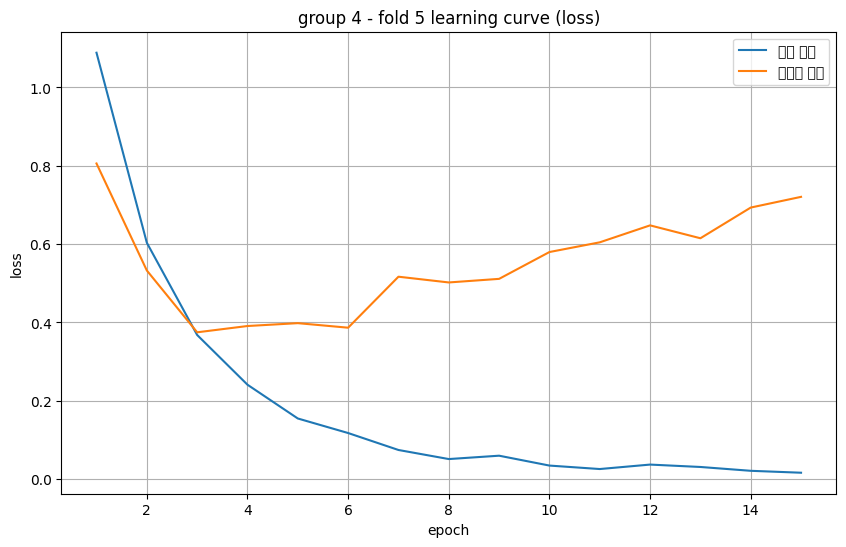

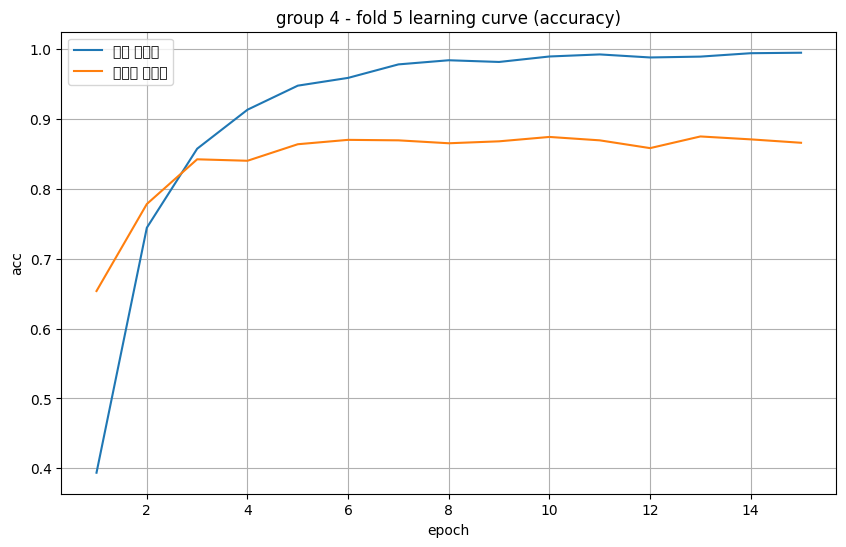

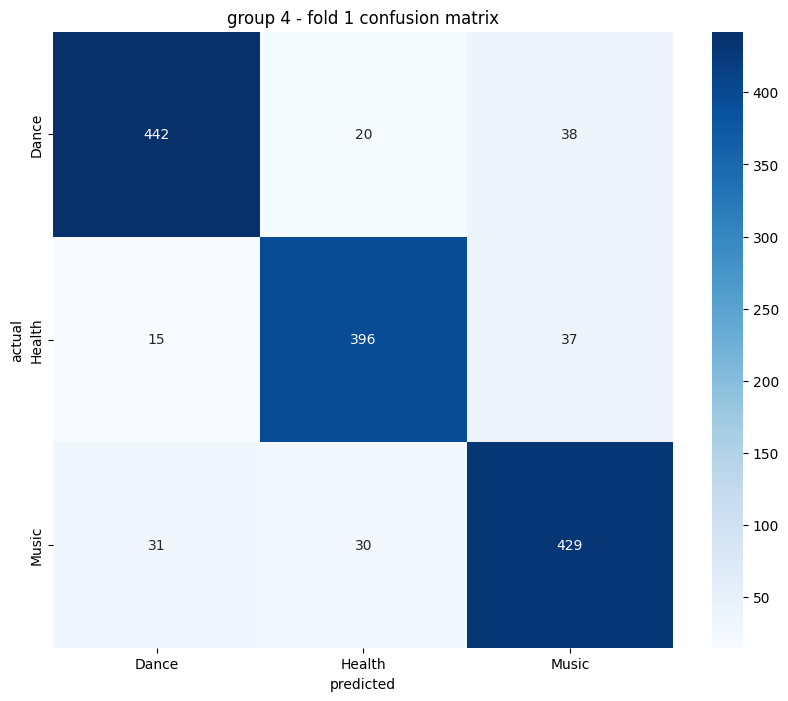

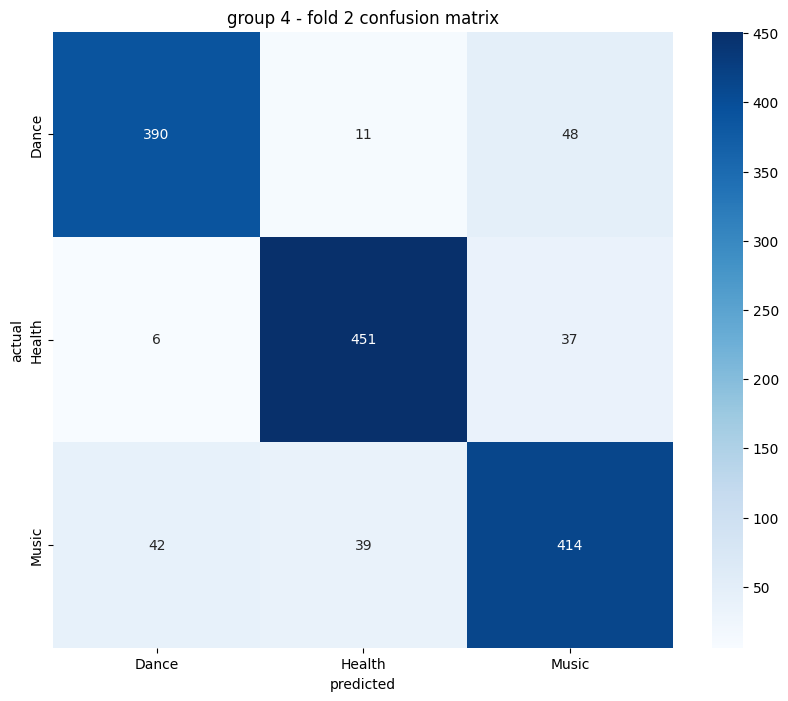

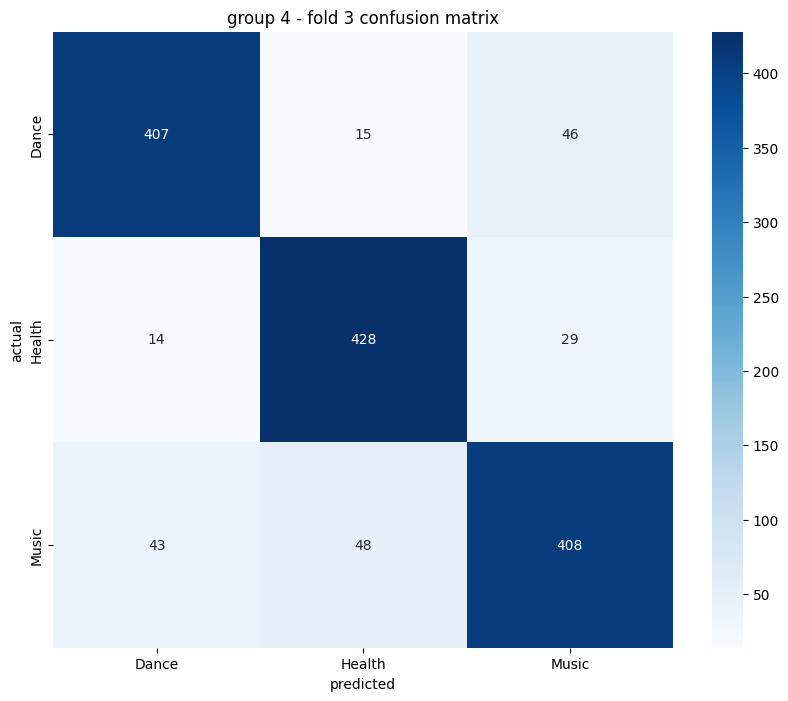

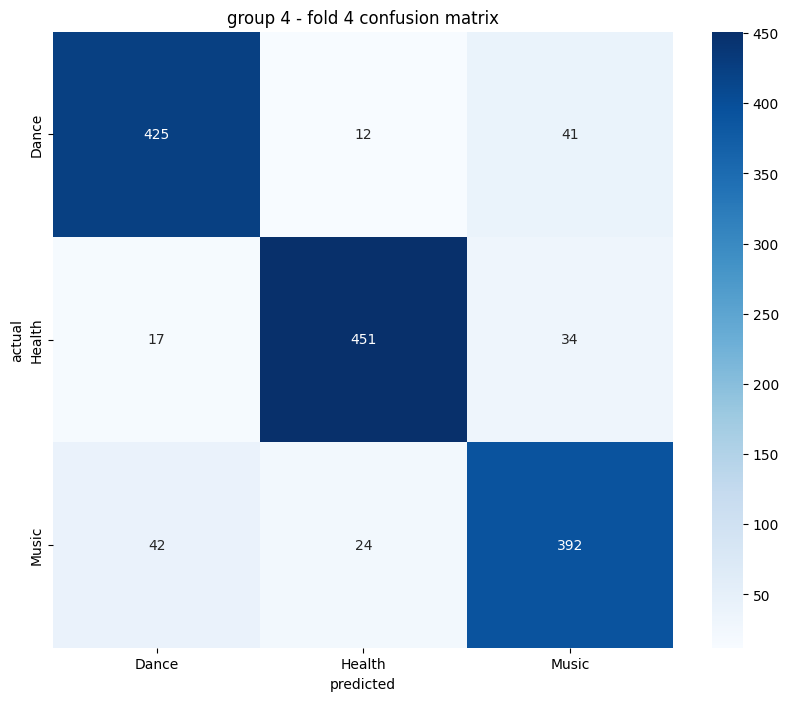

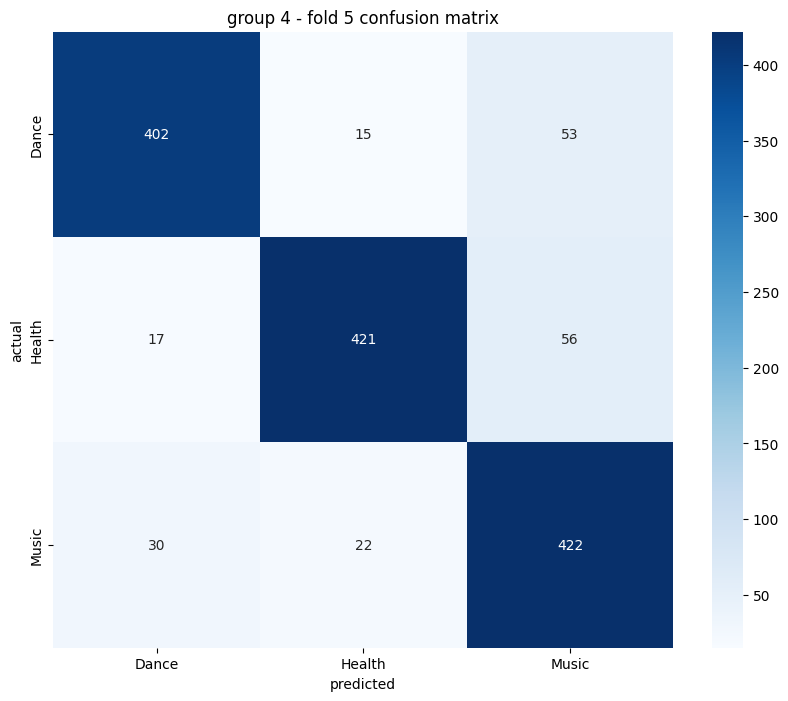


그룹 5 처리 중...

  폴드 1/5 처리 중...
    에포크 1/15: 학습 손실: 1.0532, 학습 정확도: 0.4384
                               테스트 손실: 0.9094, 테스트 정확도: 0.5619
    에포크 5/15: 학습 손실: 0.2615, 학습 정확도: 0.9134
                               테스트 손실: 0.5648, 테스트 정확도: 0.8164
    에포크 10/15: 학습 손실: 0.0809, 학습 정확도: 0.9767
                               테스트 손실: 0.7944, 테스트 정확도: 0.7990
    에포크 15/15: 학습 손실: 0.0413, 학습 정확도: 0.9903
                               테스트 손실: 1.0802, 테스트 정확도: 0.7830

  폴드 2/5 처리 중...
    에포크 1/15: 학습 손실: 1.0414, 학습 정확도: 0.4301
                               테스트 손실: 0.8325, 테스트 정확도: 0.6161
    에포크 5/15: 학습 손실: 0.2403, 학습 정확도: 0.9216
                               테스트 손실: 0.6139, 테스트 정확도: 0.7900
    에포크 10/15: 학습 손실: 0.0561, 학습 정확도: 0.9843
                               테스트 손실: 0.9211, 테스트 정확도: 0.7796
    에포크 15/15: 학습 손실: 0.0277, 학습 정확도: 0.9932
                               테스트 손실: 1.0637, 테스트 정확도: 0.7858

  폴드 3/5 처리 중...
    에포크 1/15: 학습 손실: 1.0066, 학습 정확도: 0.4763
                            

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missin

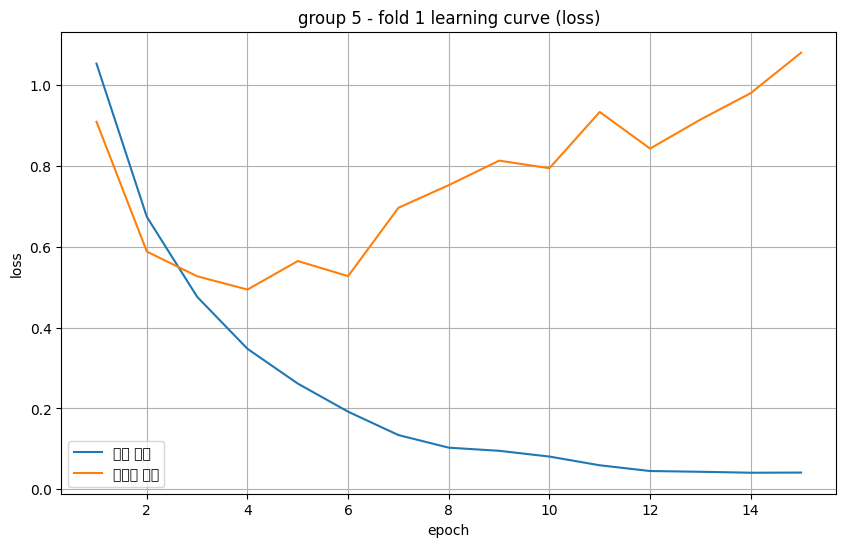

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


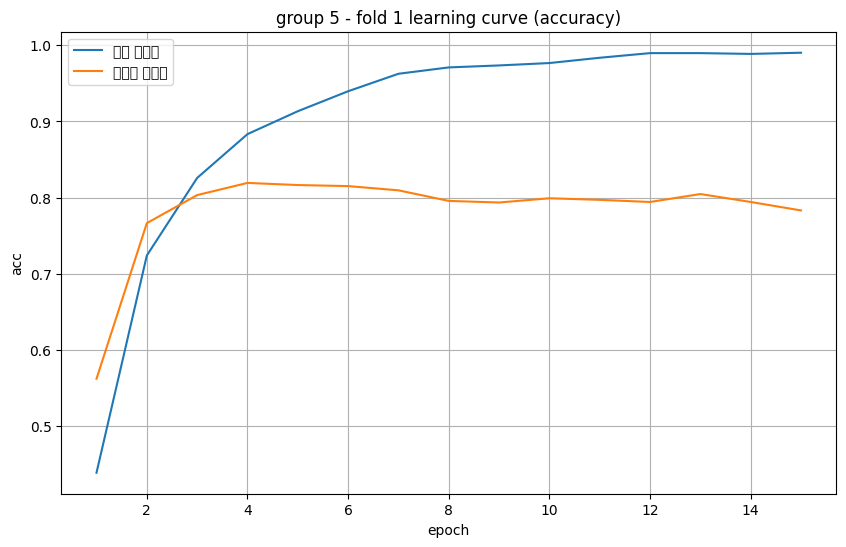

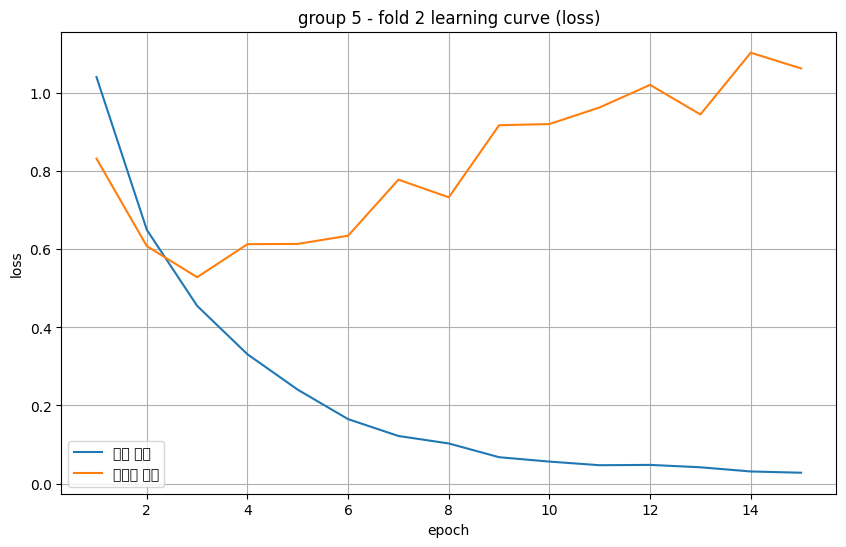

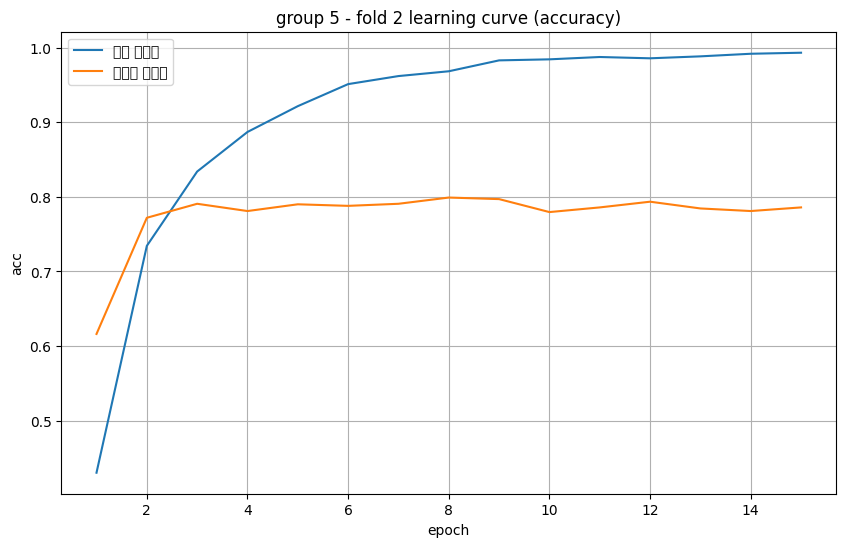

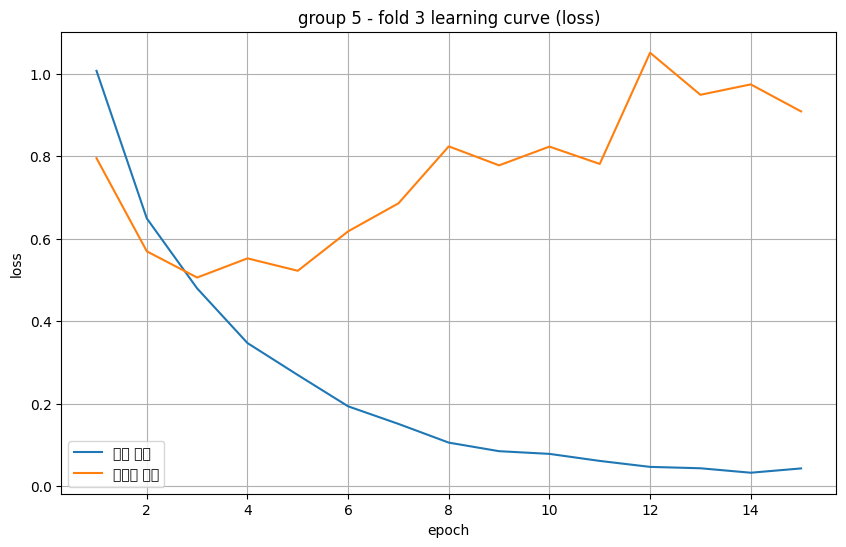

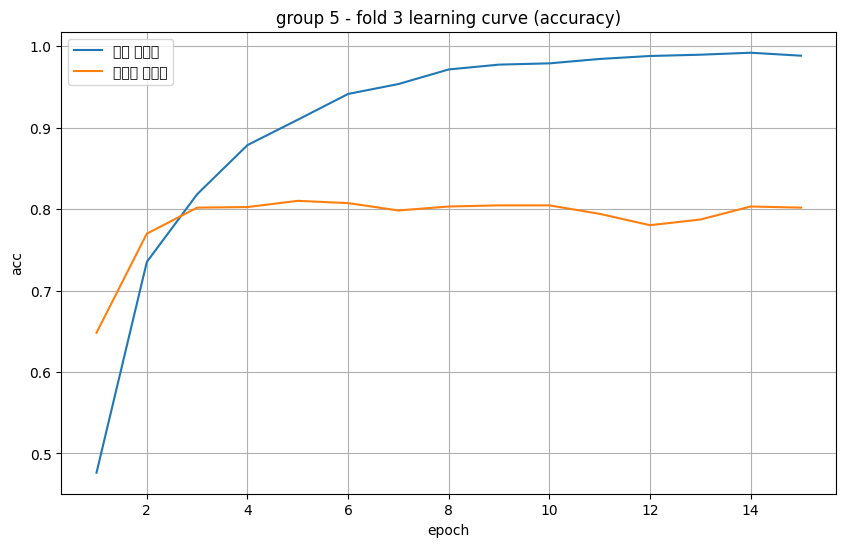

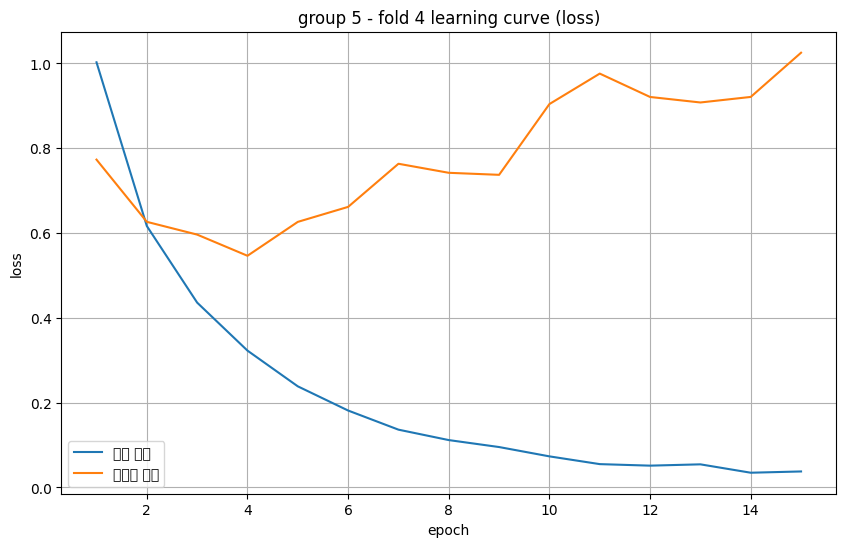

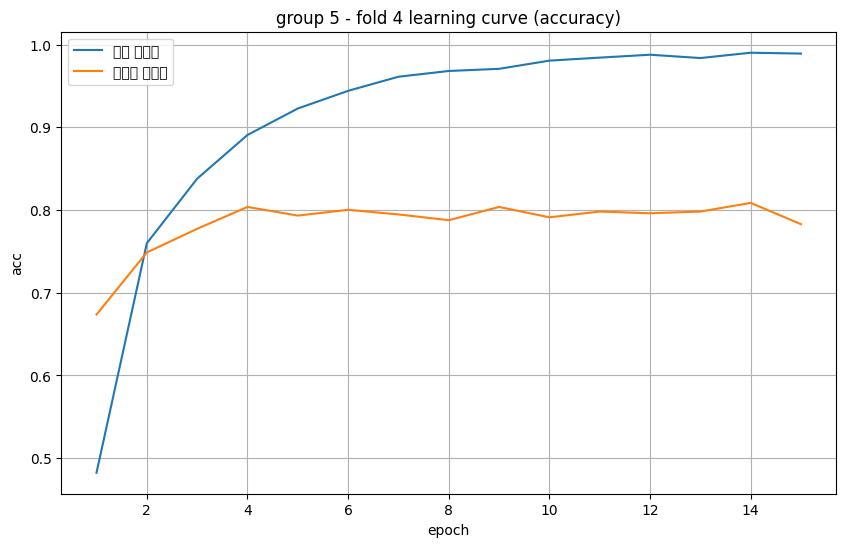

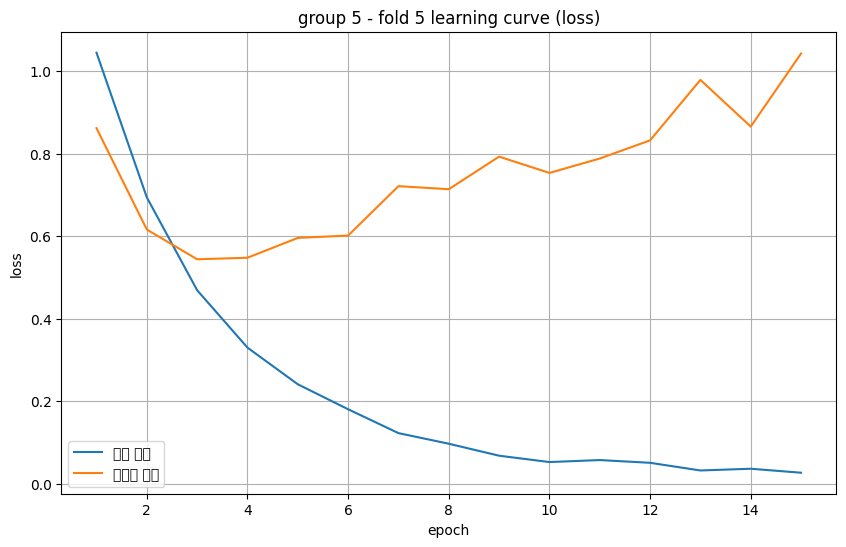

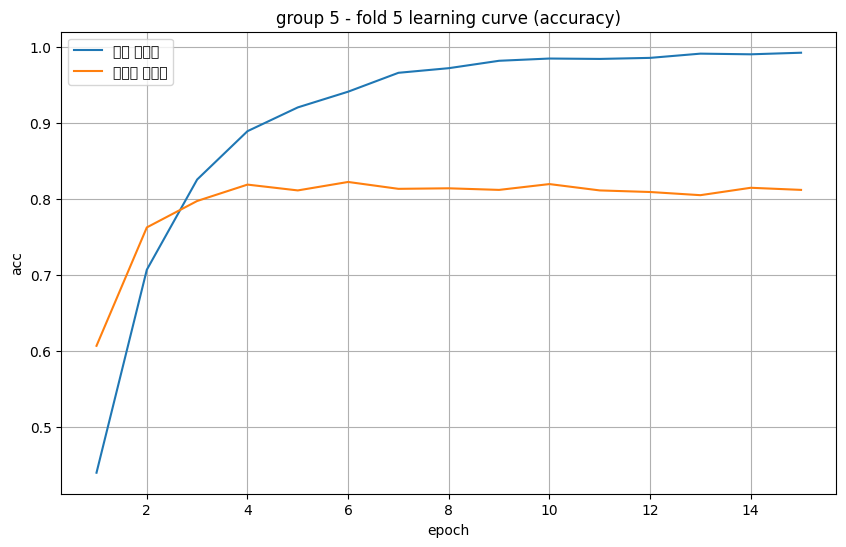

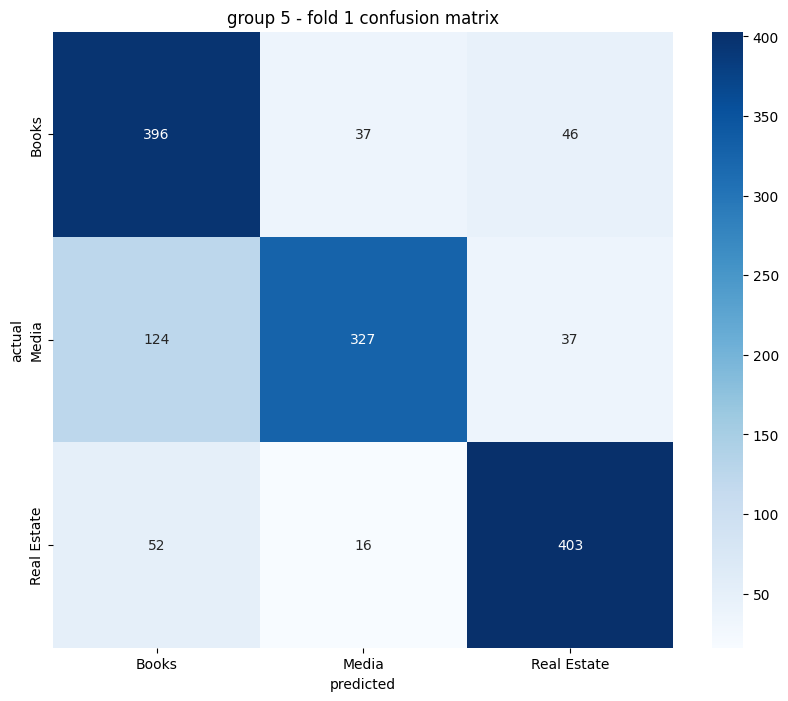

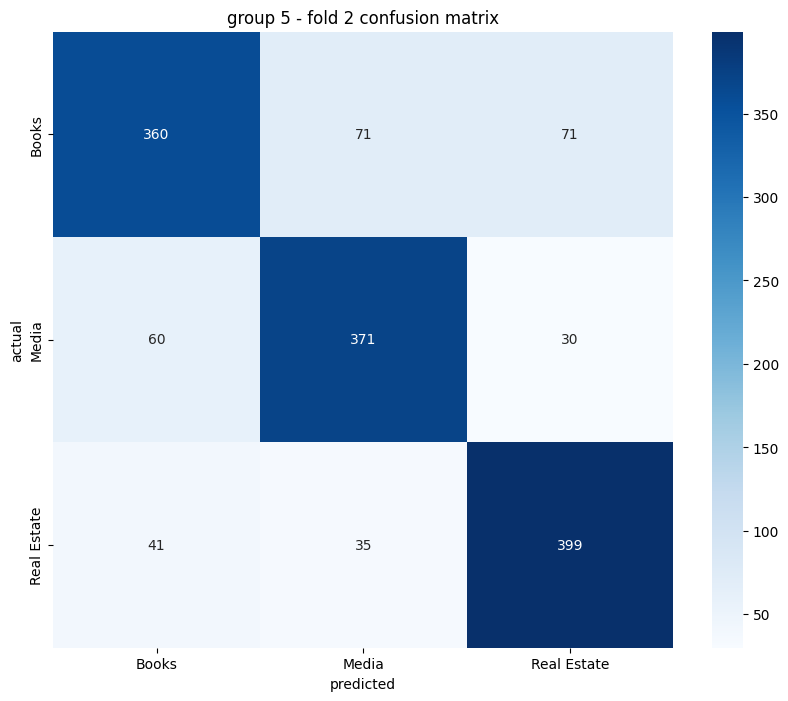

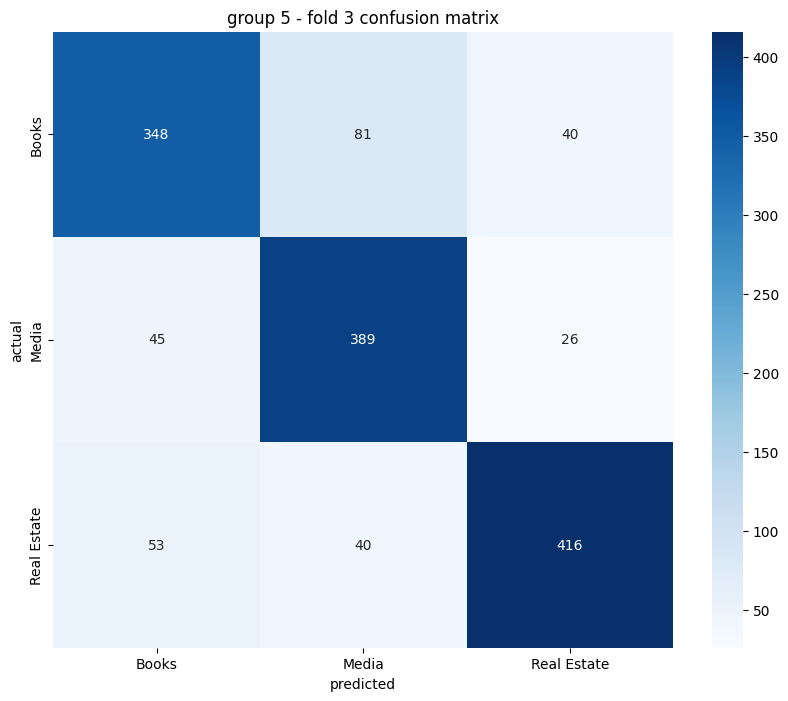

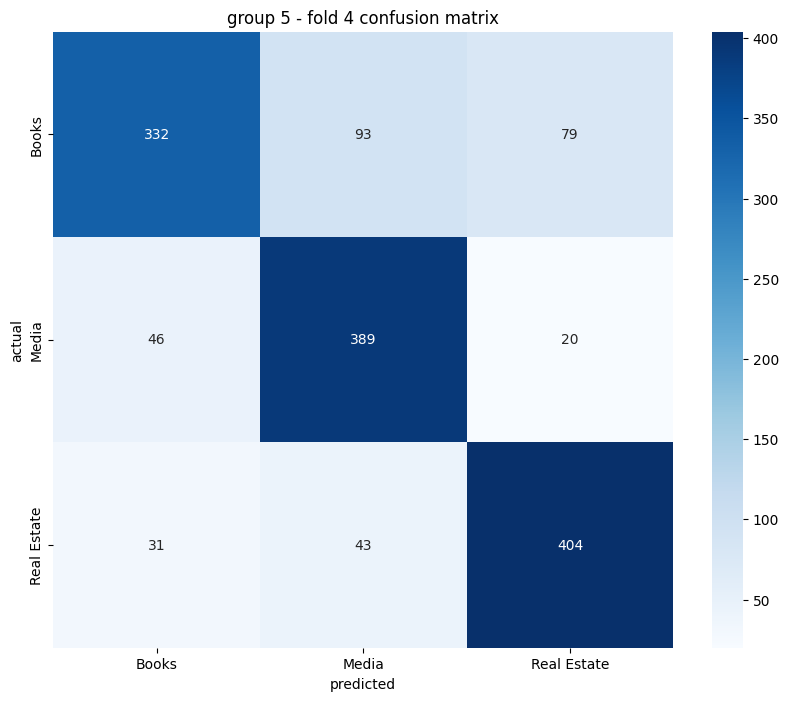

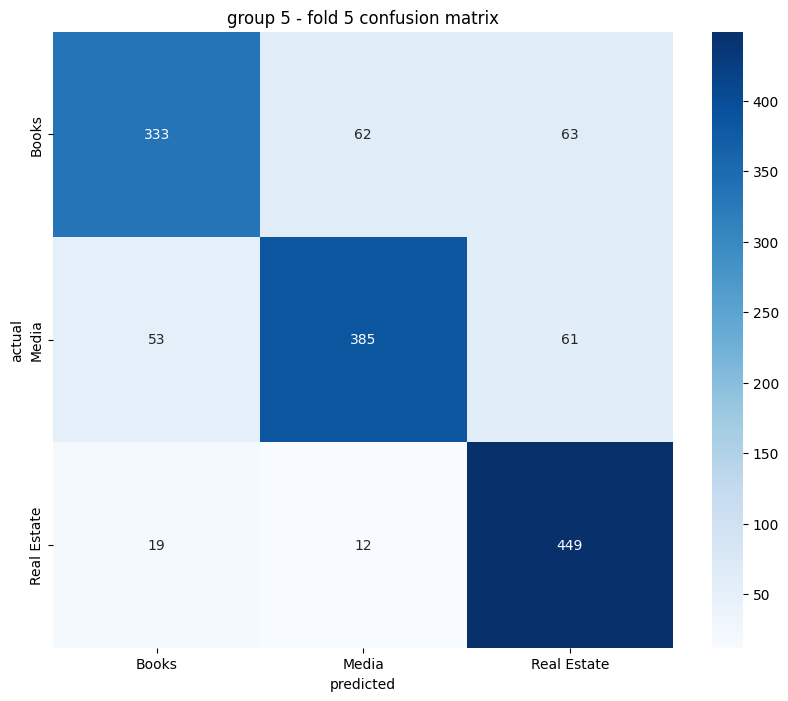


그룹 6 처리 중...

  폴드 1/5 처리 중...
    에포크 1/15: 학습 손실: 0.8793, 학습 정확도: 0.5802
                               테스트 손실: 0.6092, 테스트 정확도: 0.7632
    에포크 5/15: 학습 손실: 0.1564, 학습 정확도: 0.9496
                               테스트 손실: 0.4277, 테스트 정확도: 0.8660
    에포크 10/15: 학습 손실: 0.0375, 학습 정확도: 0.9882
                               테스트 손실: 0.6974, 테스트 정확도: 0.8562
    에포크 15/15: 학습 손실: 0.0258, 학습 정확도: 0.9915
                               테스트 손실: 0.6248, 테스트 정확도: 0.8729

  폴드 2/5 처리 중...
    에포크 1/15: 학습 손실: 0.9295, 학습 정확도: 0.5401
                               테스트 손실: 0.6449, 테스트 정확도: 0.7639
    에포크 5/15: 학습 손실: 0.1785, 학습 정확도: 0.9436
                               테스트 손실: 0.3682, 테스트 정확도: 0.8951
    에포크 10/15: 학습 손실: 0.0472, 학습 정확도: 0.9870
                               테스트 손실: 0.5050, 테스트 정확도: 0.8889
    에포크 15/15: 학습 손실: 0.0242, 학습 정확도: 0.9931
                               테스트 손실: 0.6072, 테스트 정확도: 0.8819

  폴드 3/5 처리 중...
    에포크 1/15: 학습 손실: 0.9095, 학습 정확도: 0.5606
                            

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missin

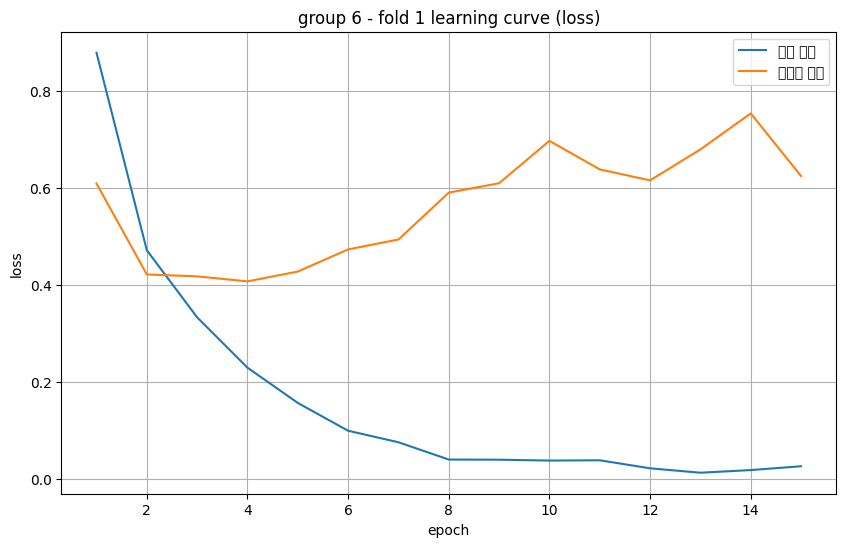

/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youlee/n24news/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


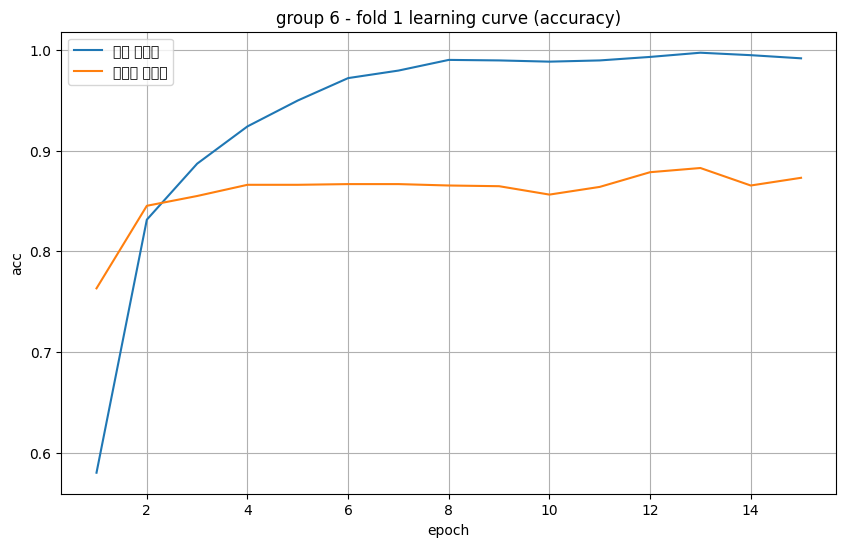

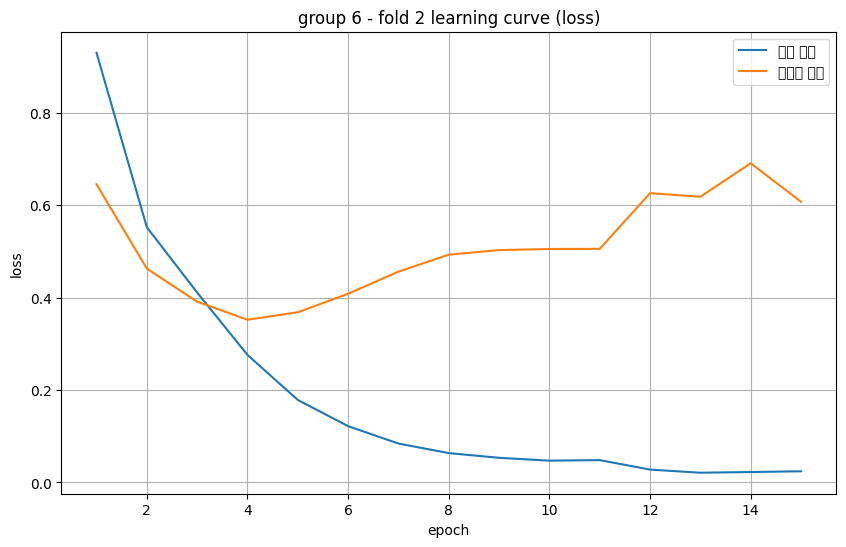

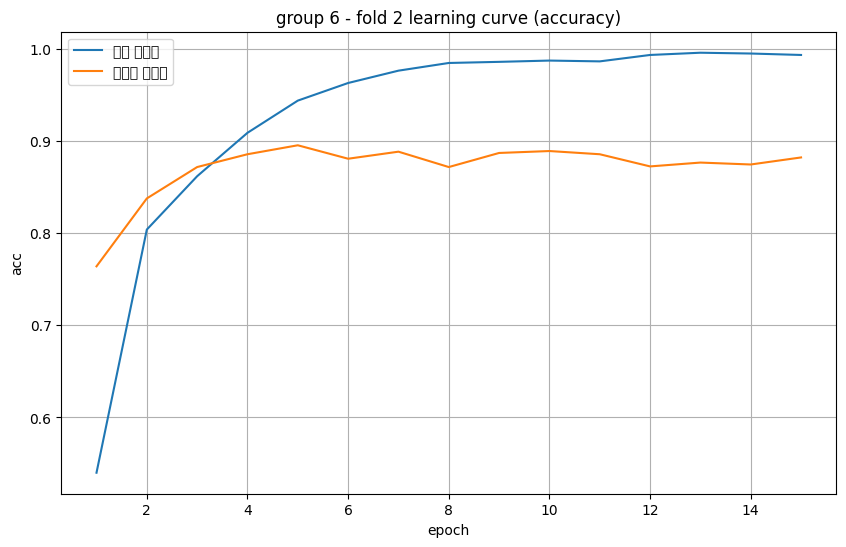

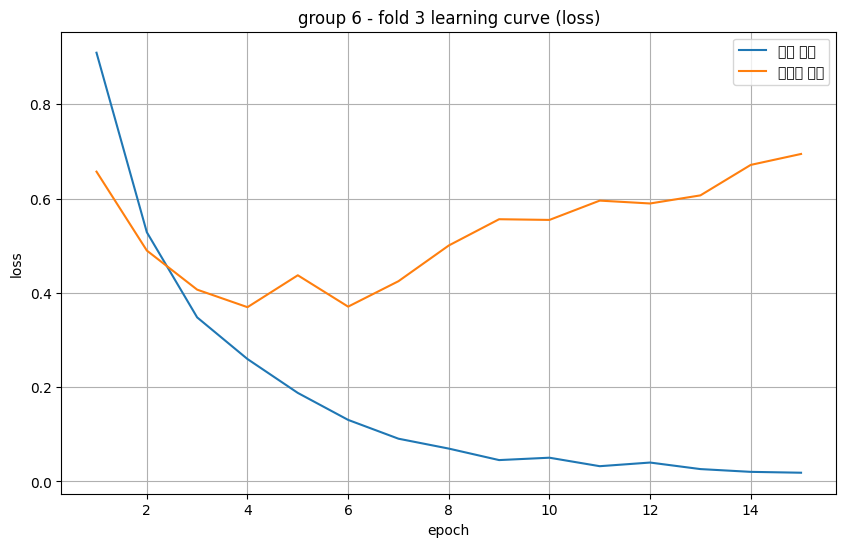

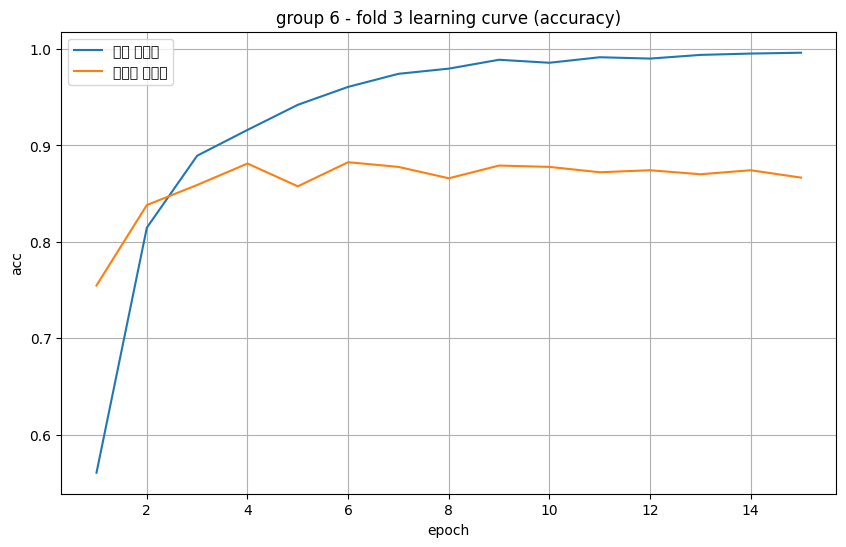

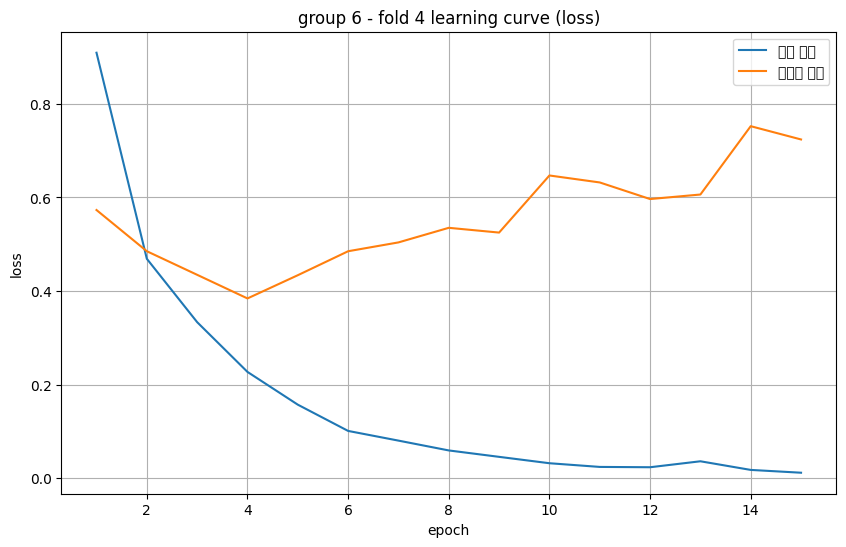

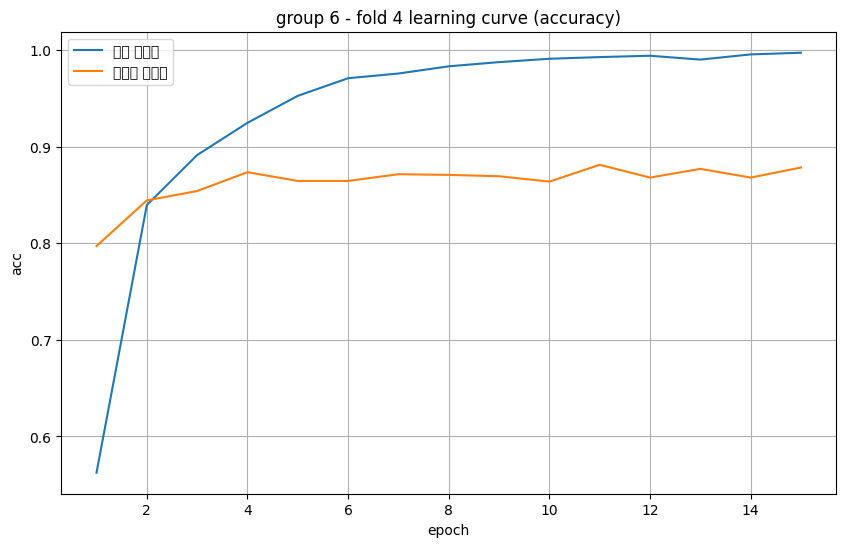

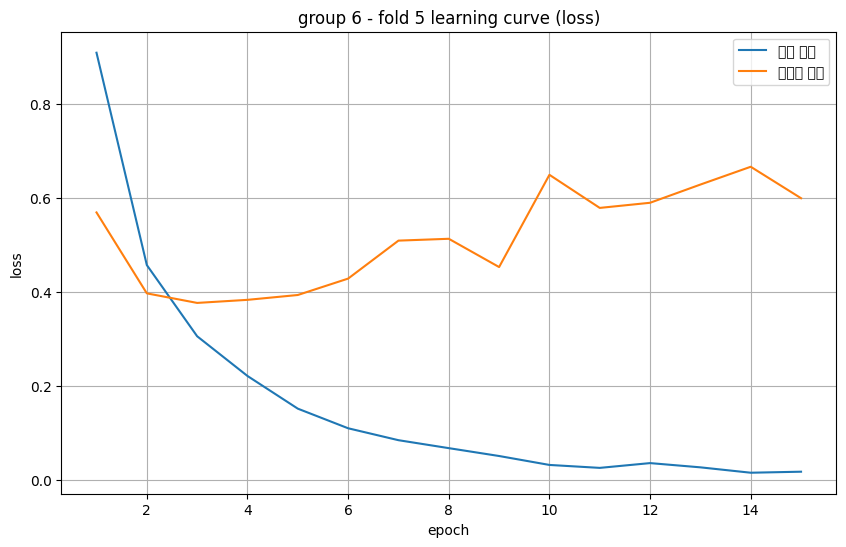

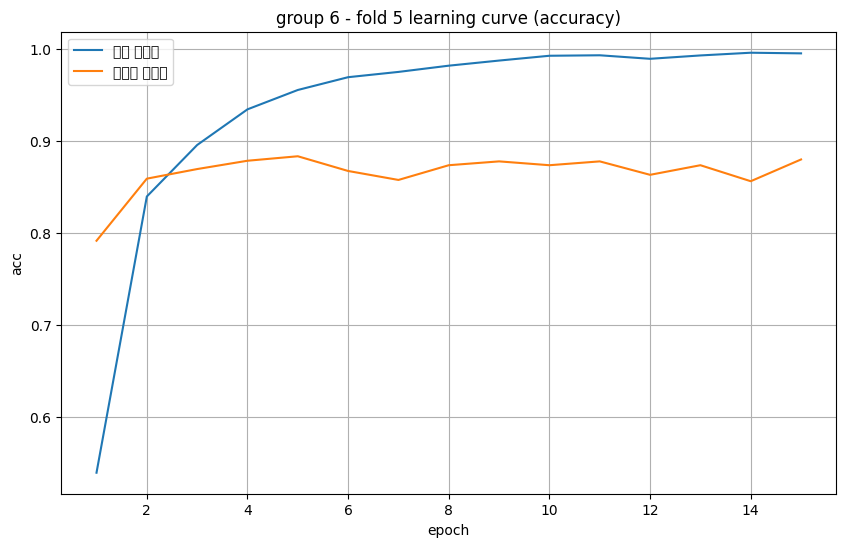

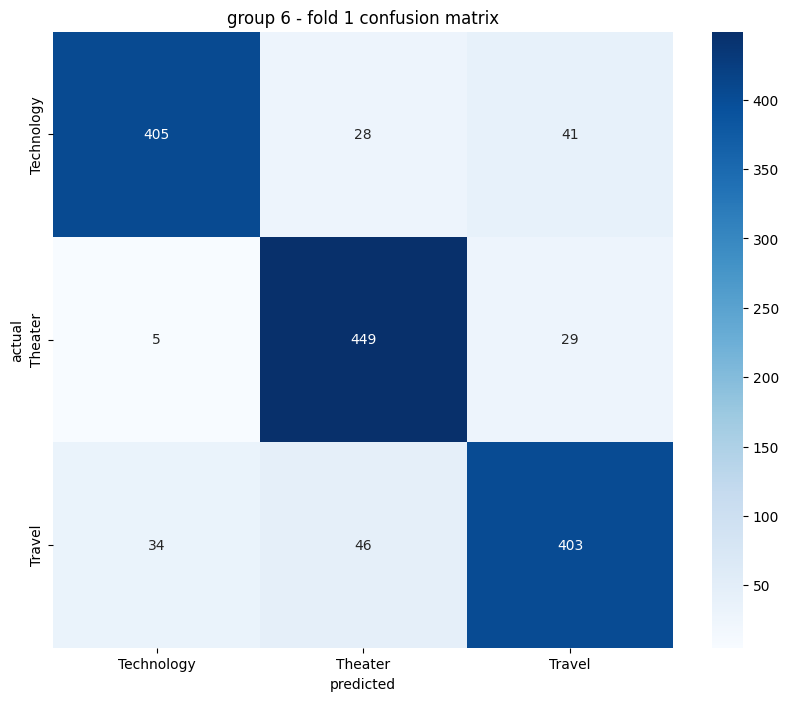

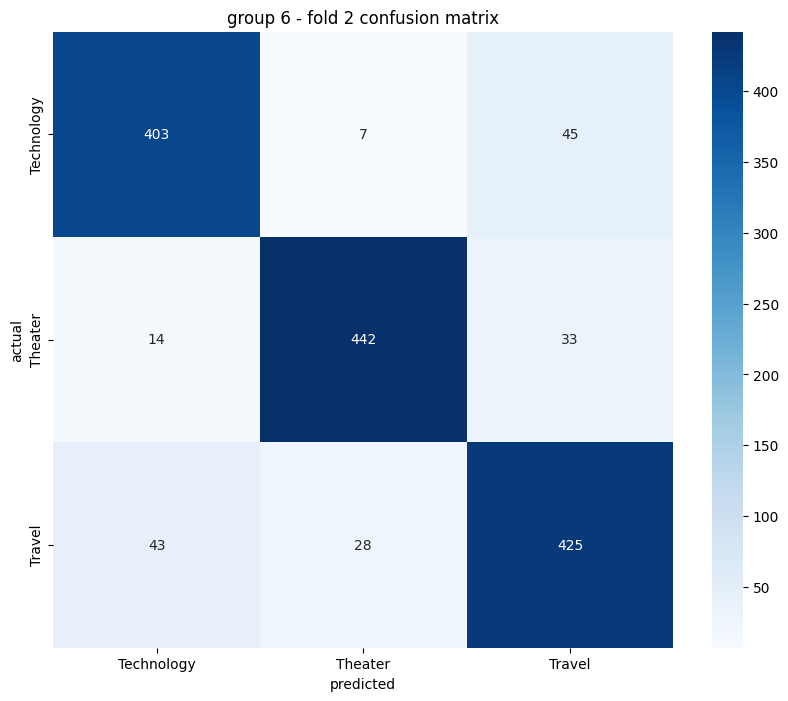

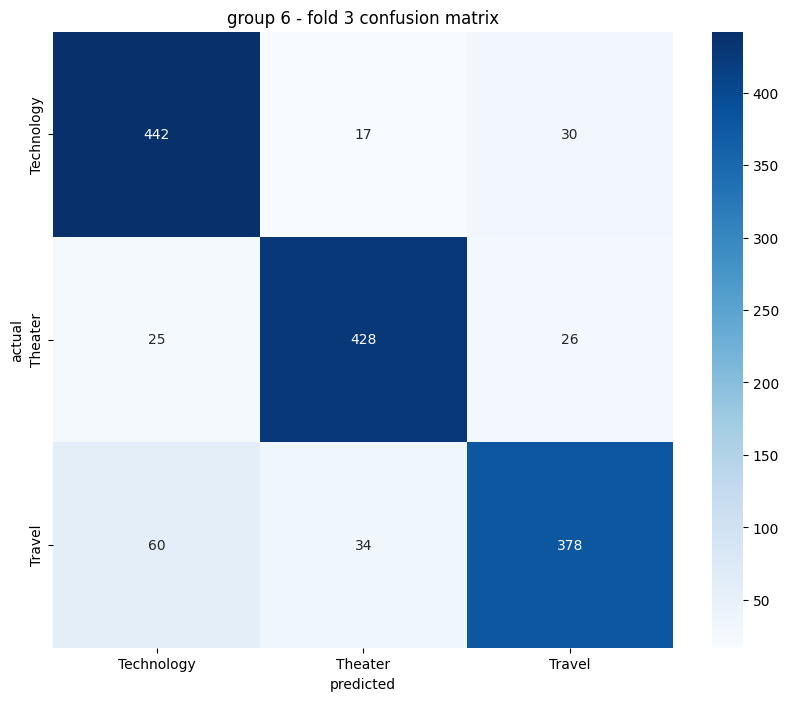

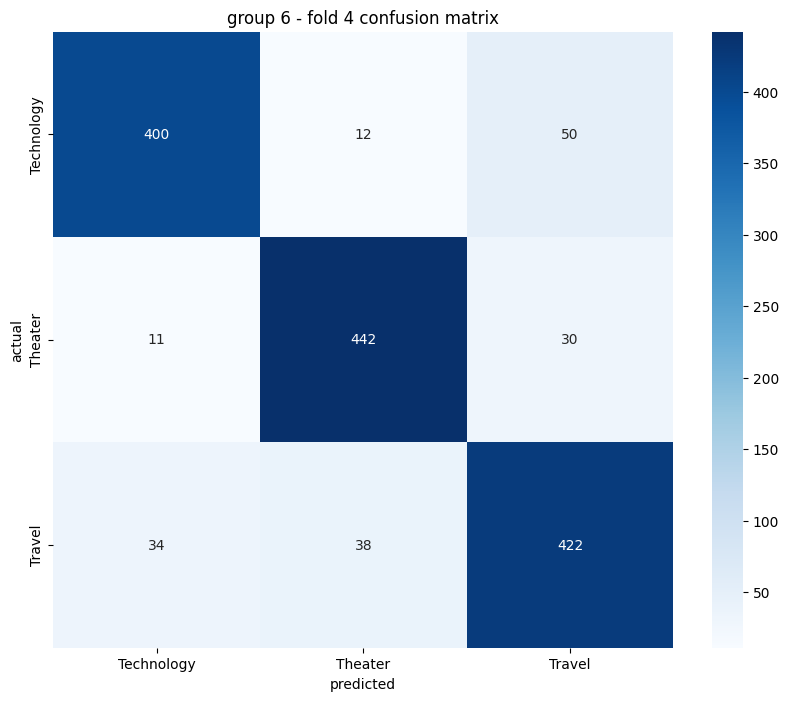

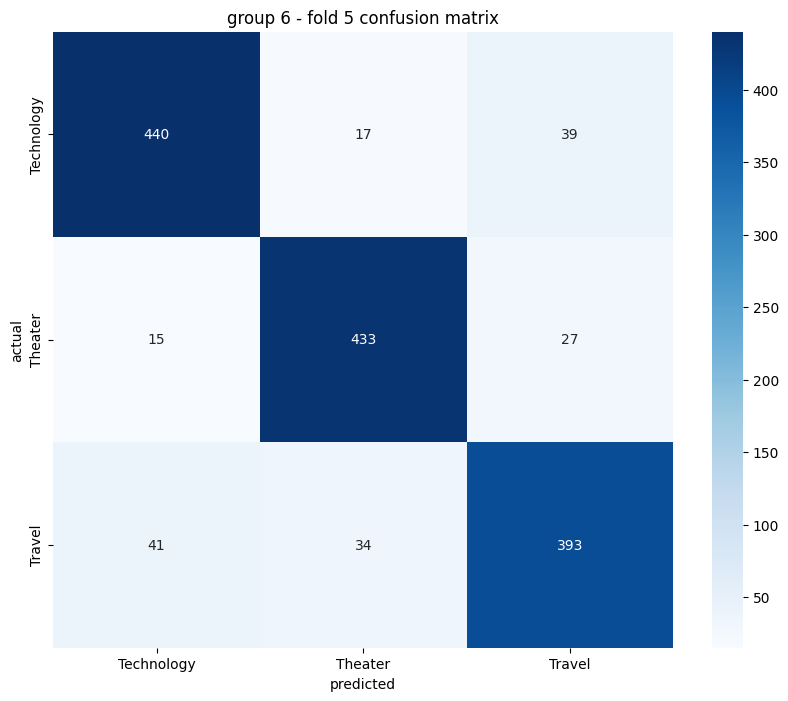

In [8]:
all_learning_curves = []

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\n그룹 {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  폴드 {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        # Perceiver 모델 초기화
        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        # CombinedModel 초기화 (임베딩 포함)
        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3) # lr

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            # 주기적으로 로그 출력
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    에포크 {epoch+1}/{EPOCHS}: 학습 손실: {train_loss:.4f}, 학습 정확도: {train_acc:.4f}')
                print(f'                               테스트 손실: {test_loss:.4f}, 테스트 정확도: {test_acc:.4f}')

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        # 테스트 세트에 대한 평가
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  # 현재 코드에서는 사용되지 않음
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })

    # 그룹에 대한 결과 집계
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

    # 그룹별 결과 출력
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    # 각 폴드에 대한 학습 곡선 시각화
    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        # 손실 곡선
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="학습 손실")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="테스트 손실")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 정확도 곡선
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="학습 정확도")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="테스트 정확도")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    # 각 폴드에 대한 혼동 행렬 시각화
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()


In [9]:
print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")



=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.8696
  폴드 1: 테스트 정확도 = 0.8551
  폴드 2: 테스트 정확도 = 0.8744
  폴드 3: 테스트 정확도 = 0.8779
  폴드 4: 테스트 정확도 = 0.8765
  폴드 5: 테스트 정확도 = 0.8640

그룹 2 - 평균 테스트 정확도: 0.7974
  폴드 1: 테스트 정확도 = 0.8112
  폴드 2: 테스트 정확도 = 0.7814
  폴드 3: 테스트 정확도 = 0.7967
  폴드 4: 테스트 정확도 = 0.8160
  폴드 5: 테스트 정확도 = 0.7819

그룹 3 - 평균 테스트 정확도: 0.8077
  폴드 1: 테스트 정확도 = 0.8115
  폴드 2: 테스트 정확도 = 0.7892
  폴드 3: 테스트 정확도 = 0.8115
  폴드 4: 테스트 정확도 = 0.8271
  폴드 5: 테스트 정확도 = 0.7991

그룹 4 - 평균 테스트 정확도: 0.8732
  폴드 1: 테스트 정확도 = 0.8811
  폴드 2: 테스트 정확도 = 0.8727
  폴드 3: 테스트 정확도 = 0.8644
  폴드 4: 테스트 정확도 = 0.8818
  폴드 5: 테스트 정확도 = 0.8658

그룹 5 - 평균 테스트 정확도: 0.7931
  폴드 1: 테스트 정확도 = 0.7830
  폴드 2: 테스트 정확도 = 0.7858
  폴드 3: 테스트 정확도 = 0.8018
  폴드 4: 테스트 정확도 = 0.7829
  폴드 5: 테스트 정확도 = 0.8121

그룹 6 - 평균 테스트 정확도: 0.8759
  폴드 1: 테스트 정확도 = 0.8729
  폴드 2: 테스트 정확도 = 0.8819
  폴드 3: 테스트 정확도 = 0.8667
  폴드 4: 테스트 정확도 = 0.8784
  폴드 5: 테스트 정확도 = 0.8798
